# What drives the price of a car?

<center>
    <img src = ../images/kurt.jpeg width = 100%/>
</center>


**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

In [281]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

In [282]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

### CRISP-DM Framework

<center>
    <img src = ../images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Background: 

From a business perspective, we are tasked with identifying key drivers for used car prices.

#### Business objective:

In this practical application “What drives the price of a car?” our goal is to develop a model to understand the factors influencing the price of used cars. 

We need to identify, analyze and try to quantify the relationships between car attributes and their market price for the benefit of the stake holders (car dealership and consumers). This involves analyzing the dataset to uncover patterns, correlations, and trends that affect pricing, with the ultimate objective of constructing a regression model to predict car prices based on these factors. 

##### For this project the success criteria would be: 

Car dealerships needs to understand

- which car attributes (e.g., make, model, age, mileage, color) most significantly affect pricing, to make informed decisions about which cars to stock
- the key drivers to better negotiate prices with customers, decide which deals to offer, and identify the cars that are in high demand to keep in stock

#### Assess Situation: 

For this analysis, we have been provided with a vehicle dataset containing 426k cars. The main challenge here is that the dataset may contain outliers and missing values, which could skew our analysis or reduce the quality of the model. Removing or imputing missing data and handling outliers will be critical steps to ensure the dataset is usable and robust for training and testing predictive models. 

#### Data mining goals: 

We will primarily use regression modeling to identify and quantify the factors that most influence the price of used cars. We will focus on understanding the relationship between independent variables (like make, model, year, mileage, condition, etc.) and the dependent variable (price).


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

As part of the Data Understanding we will look into Collected initial data, Describe the data, Explore the data and verify the quality of the collected data.

#### Verify the data quality:

We need to validate the quality of data by checking are the data generally accurate, or are there systemic issues like repeated errors in certain columns? Are there many missing or inconsistent values? How should they be handled? Are there any columns with high redundancy or irrelevant information? This will help us to prepare the data.


#### Collected initial data: 

The vehicles.csv dataset for this modeling was provided includes 426k records

In [289]:
# As a first step load the data into a df
data=pd.read_csv('data/vehicles.csv')

#### Describe data: 
    
Vehicles dataset includes 18 attributes/features with 426880 records.

In [291]:
# View the data
print(data.shape)

(426880, 18)


In [292]:
data.head()

id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma  
4  NaN  NaN         NaN    nc

In [293]:
data.describe()

id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07

#### Explore the data: 

We need to remove or impute missing data and handle outliers. These would be critical next steps to ensure the dataset is usable and robust for training and testing predictive models.

In [295]:
# Lets review the dataframe attributes/features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [296]:
# explore Columns that are null in relation to the total number of columns as %s
null_percentage = data.isnull().mean() * 100
missing_columns = null_percentage[null_percentage > 0]

for column, percentage in missing_columns.items():
    print(f"{column}: {percentage:.2f}%")

year: 0.28%
manufacturer: 4.13%
model: 1.24%
condition: 40.79%
cylinders: 41.62%
fuel: 0.71%
odometer: 1.03%
title_status: 1.93%
transmission: 0.60%
VIN: 37.73%
drive: 30.59%
size: 71.77%
type: 21.75%
paint_color: 30.50%


In [297]:
#Check the Null Columns
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [298]:
# As the standard practice in exploring data, let's review the correlation of the dataset with the missing values
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=['number'])  
correlation_matrix = numeric_data.corr()  
correlation_matrix

id     price      year  odometer
id        1.000000 -0.002779 -0.059040  0.010721
price    -0.002779  1.000000 -0.004925  0.010032
year     -0.059040 -0.004925  1.000000 -0.157215
odometer  0.010721  0.010032 -0.157215  1.000000

In [299]:
# We can see now that there is a weak correlation between the price, year and odometer. 
# Obviously the Car id is a unique data identifier which is irrelevant so lets remove that for our analysis
data_v1 = data.drop('id', axis=1).select_dtypes(include=['number'])  
data_v1.corr()

price      year  odometer
price     1.000000 -0.004925  0.010032
year     -0.004925  1.000000 -0.157215
odometer  0.010032 -0.157215  1.000000

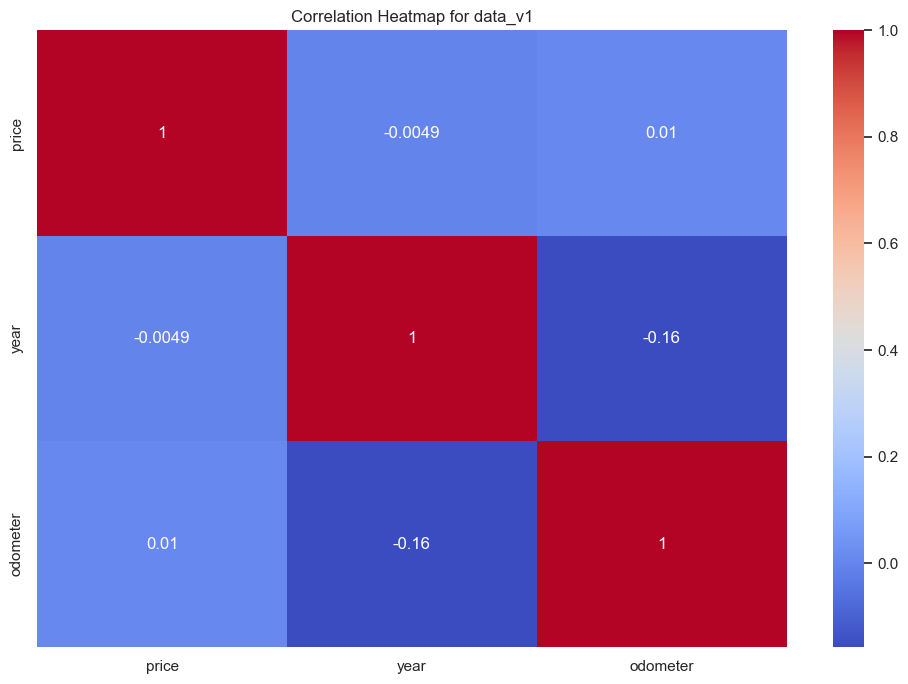

In [300]:
# As you can see from the above there is no diff even after removing the id column
# Lets explore some visualization of the data1

# Set the figure size and layout
fig, ax = plt.subplots(figsize=(10, 7))
plt.rcParams["figure.autolayout"] = True

# Create a seaborn heatmap for the correlation matrix
# Ensure data1 is a DataFrame with numeric values
ax = sns.heatmap(data_v1.corr(), annot=True, cmap='coolwarm')  

# Add a Title to the Plot
ax.set_title("Correlation Heatmap for data_v1")

# Make the plot full screen
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()

# Display the plot
plt.show()

`As you can see from the above the Values are close to 0 which indicate a weak relationship`
- Generally we expect a strong correlation like the lower the odometer, year the higher the price etc
- lets see the scatter plot to analyze is this due to missing or null values

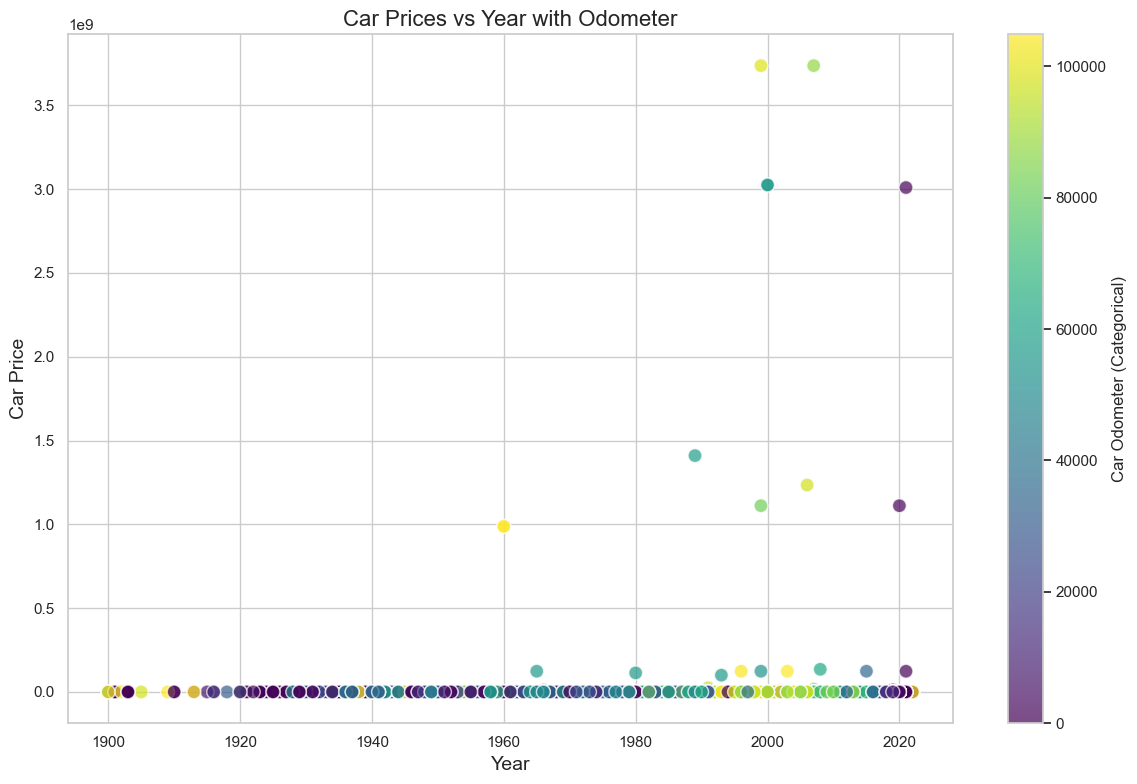

In [302]:

# Scatter plot of year vs car price with odometer
plt.figure(figsize=(12, 8))

# Lets use a scatter plot with color based on odometer variable 
scatter = plt.scatter(data['year'], data['price'], 
                      c=data['odometer'].astype('category').cat.codes,  
                      cmap='viridis',  
                      alpha=0.7,  
                      edgecolor='w',  
                      s=100)  

# Add a Title to the Plot
plt.title("Car Prices vs Year with Odometer", fontsize=16)

# Setting the X and Y labels
plt.xlabel('Year', fontsize=14)
plt.ylabel('Car Price', fontsize=14)

# Adding a color bar to indicate the variable represented by color
cbar = plt.colorbar(scatter)
cbar.set_label('Car Odometer (Categorical)', fontsize=12)  

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()

`We can now be more certain that the missing and NaN values in the datasets are skewing the visualizations the line of 0.0 are mostly due to missing Car Prices. The latest year and even zero odometer reading shows zero price`

In [304]:
# We in 2024 know that before Covid the prices hit bottom and then used car prices skyrocketed due to supply chain issues
# so lets drop the missing / null values and define another df to analyze our understanding

data_v2 = data.query("price > 0").dropna()
data_v2

id      region  price    year   manufacturer            model  \
215     7316482063  birmingham   4000  2002.0         toyota             echo   
219     7316429417  birmingham   2500  1995.0            bmw             525i   
268     7315946365  birmingham   9000  2008.0          mazda       miata mx-5   
337     7315354216  birmingham   8950  2011.0           ford            f-150   
338     7315349921  birmingham   4000  1972.0  mercedes-benz             benz   
...            ...         ...    ...     ...            ...              ...   
426785  7303314912     wyoming  23495  2015.0           ford     f150 xlt 4x4   
426788  7303227528     wyoming  12995  2016.0      chevrolet         cruze lt   
426792  7303114896     wyoming  32999  2014.0           ford        f350, xlt   
426793  7303112347     wyoming  15999  2018.0      chevrolet        cruze, lt   
426833  7302338378     wyoming   6800  1997.0         jaguar  xk8 convertible   

        condition    cylinders    fuel  odometer title_status transmission  \
215     excellent  4 cylinders     gas  155000.0        clean    automatic   
219          fair  6 cylinders     gas  110661.0        clean    automatic   
268     excellent  4 cylinders     gas   56700.0        clean    automatic   
337     excellent  6 cylinders     gas  164000.0        clean    automatic   
338          fair  6 cylinders     gas   88100.0        clean    automatic   
...           ...          ...     ...       ...          ...          ...   
426785   like new  8 cylinders     gas  146795.0        clean    automatic   
426788   like new  4 cylinders     gas   61127.0        clean    automatic   
426792  excellent  8 cylinders  diesel  154642.0        clean    automatic   
426793  excellent  4 cylinders     gas   36465.0        clean    automatic   
426833       good  8 cylinders     gas   69550.0        clean    automatic   

                      VIN drive       size         type paint_color state  
215     JTDBT123520243495   fwd    compact        sedan        blue    al  
219     WBAHD6322SGK86772   rwd   mid-size        sedan       white    al  
268     JM1NC25F570128735   rwd    compact  convertible       white    al  
337     1FTMF1CM6BKD55331   fwd  full-size        truck       white    al  
338           1.14023E+13   rwd  full-size        coupe      silver    al  
...                   ...   ...        ...          ...         ...   ...  
426785  1FTFX1EF5FFC24427   4wd  full-size        truck       black    wy  
426788  1G1BE5SM0G7266569   fwd    compact        sedan      silver    wy  
426792  1FT8W3DT3EEB41548   4wd  full-size       pickup       brown    wy  
426793  1G1BE5SM7J7133704   fwd   mid-size        sedan       black    wy  
426833  SAJGX2749VCOO8376   rwd    compact  convertible       white    wy  

[32496 rows x 18 columns]

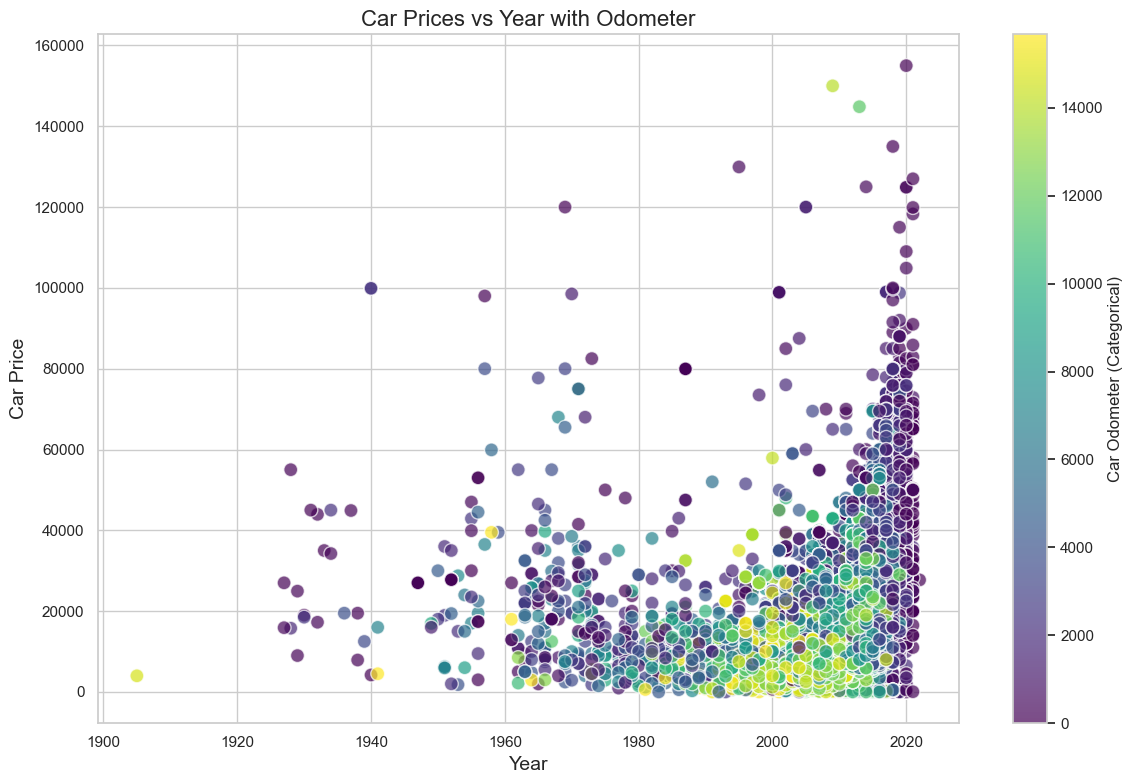

In [305]:
#Dropping null and missing values reduced the dataset to 32K
# now lets look at the same scatter plot again

# Scatter plot of year vs car price with odometer
plt.figure(figsize=(12, 8))

# Lets use a scatter plot with color based on odometer variable 
scatter = plt.scatter(data_v2['year'], data_v2['price'], 
                      c=data_v2['odometer'].astype('category').cat.codes,  
                      cmap='viridis',  
                      alpha=0.7,  
                      edgecolor='w',  
                      s=100)  

# Add a Title to the Plot
plt.title("Car Prices vs Year with Odometer", fontsize=16)

# Setting the X and Y labels
plt.xlabel('Year', fontsize=14)
plt.ylabel('Car Price', fontsize=14)

# Adding a color bar to indicate the variable represented by color
cbar = plt.colorbar(scatter)
cbar.set_label('Car Odometer (Categorical)', fontsize=12)  

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()

`The cleaned dataset v2 is still skewed towards very low values which is shown above, data is crowded for lower values.
Lets see the min and max values of odometer and price based on current record selection`

In [307]:
print("Minimum Price : data_v2: ", data_v2['price'].min())
print("Maximum Price : data_v2: ", data_v2['price'].max())
print("Minimum Odometer : data_v2: ", data_v2['odometer'].min())
print("Maximum Odometer : data_v2: ", data_v2['odometer'].max())

Minimum Price : data_v2:  1
Maximum Price : data_v2:  155000
Minimum Odometer : data_v2:  0.0
Maximum Odometer : data_v2:  9999999.0


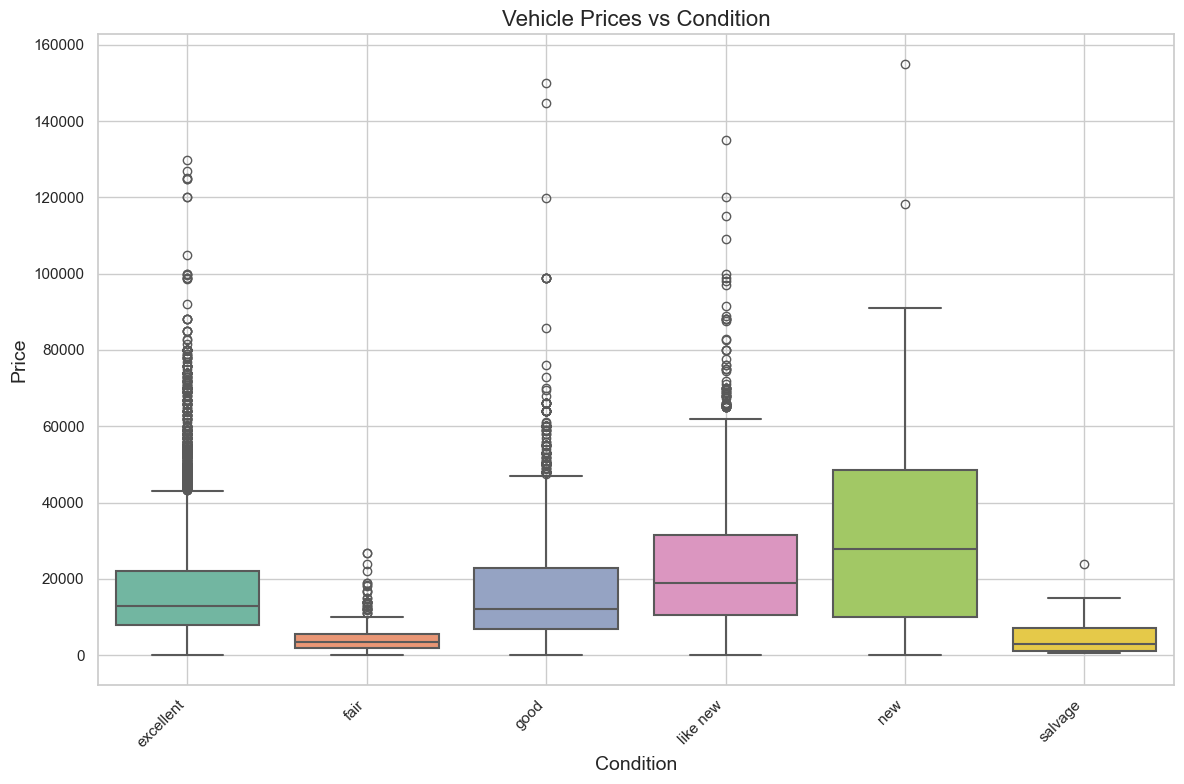

In [308]:
# Now lets see the Price vs Condition of the vehicles

# For better aesthetics
sns.set(style="whitegrid")

# figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# boxplot with improved aesthetics
sns.boxplot(x=data_v2["condition"], y=data_v2["price"], ax=ax, 
            palette="Set2",  
            linewidth=1.5)  

# Title 
ax.set_title("Vehicle Prices vs Condition", fontsize=16)

# Set the X and Y labels
ax.set_xlabel("Condition", fontsize=14)
ax.set_ylabel("Price", fontsize=14)

# Rotate x-tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show grid 
ax.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

`Now the above plot shows that "new","excellent", "like new" and "good" car conditions are higher priced. Salvage and fair have the lower prices
Irrespective of condition of the vehicle we have zero dollar car prices which shows the missing/bad data`

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [311]:
# Lets create a new df of the loaded dataset and dropping null rows
data_v3 = data.copy().dropna()
data_v3.head()

id      region  price    year manufacturer              model  \
126  7305672709      auburn      0  2018.0    chevrolet  express cargo van   
127  7305672266      auburn      0  2019.0    chevrolet  express cargo van   
128  7305672252      auburn      0  2018.0    chevrolet  express cargo van   
215  7316482063  birmingham   4000  2002.0       toyota               echo   
219  7316429417  birmingham   2500  1995.0          bmw               525i   

     condition    cylinders fuel  odometer title_status transmission  \
126   like new  6 cylinders  gas   68472.0        clean    automatic   
127   like new  6 cylinders  gas   69125.0        clean    automatic   
128   like new  6 cylinders  gas   66555.0        clean    automatic   
215  excellent  4 cylinders  gas  155000.0        clean    automatic   
219       fair  6 cylinders  gas  110661.0        clean    automatic   

                   VIN drive       size   type paint_color state  
126  1GCWGAFP8J1309579   rwd  full-size    van       white    al  
127  1GCWGAFP4K1214373   rwd  full-size    van       white    al  
128  1GCWGAFPXJ1337903   rwd  full-size    van       white    al  
215  JTDBT123520243495   fwd    compact  sedan        blue    al  
219  WBAHD6322SGK86772   rwd   mid-size  sedan       white    al

In [312]:
#Shape of the data
data_v3.shape

(34868, 18)

In [313]:
# Lets drop the features that are not useful for us in predicting the price based on above observations
data_v3.drop('id', axis=1, inplace=True)
data_v3.drop('VIN', axis=1, inplace=True)
data_v3.drop('region', axis=1, inplace=True)
data_v3

price    year manufacturer              model  condition    cylinders  \
126         0  2018.0    chevrolet  express cargo van   like new  6 cylinders   
127         0  2019.0    chevrolet  express cargo van   like new  6 cylinders   
128         0  2018.0    chevrolet  express cargo van   like new  6 cylinders   
215      4000  2002.0       toyota               echo  excellent  4 cylinders   
219      2500  1995.0          bmw               525i       fair  6 cylinders   
...       ...     ...          ...                ...        ...          ...   
426788  12995  2016.0    chevrolet           cruze lt   like new  4 cylinders   
426792  32999  2014.0         ford          f350, xlt  excellent  8 cylinders   
426793  15999  2018.0    chevrolet          cruze, lt  excellent  4 cylinders   
426833   6800  1997.0       jaguar    xk8 convertible       good  8 cylinders   
426836      0  2018.0          ram               2500  excellent  6 cylinders   

          fuel  odometer title_status transmission drive       size  \
126        gas   68472.0        clean    automatic   rwd  full-size   
127        gas   69125.0        clean    automatic   rwd  full-size   
128        gas   66555.0        clean    automatic   rwd  full-size   
215        gas  155000.0        clean    automatic   fwd    compact   
219        gas  110661.0        clean    automatic   rwd   mid-size   
...        ...       ...          ...          ...   ...        ...   
426788     gas   61127.0        clean    automatic   fwd    compact   
426792  diesel  154642.0        clean    automatic   4wd  full-size   
426793     gas   36465.0        clean    automatic   fwd   mid-size   
426833     gas   69550.0        clean    automatic   rwd    compact   
426836  diesel   20492.0        clean    automatic   4wd  full-size   

               type paint_color state  
126             van       white    al  
127             van       white    al  
128             van       white    al  
215           sedan        blue    al  
219           sedan       white    al  
...             ...         ...   ...  
426788        sedan      silver    wy  
426792       pickup       brown    wy  
426793        sedan       black    wy  
426833  convertible       white    wy  
426836        truck       white    wy  

[34868 rows x 15 columns]

In [314]:
#Check on which features are having nulls
data_v3.isnull().sum()


price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [315]:
# No null values so lets check on features with zero values
data_v3.eq(0).any()

price            True
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

In [316]:
# price and odometer are having some zero values so lets see that count
price_zero_count = (data_v3['price'] == 0).sum()
print('Count of zeros in price : ', price_zero_count)
odometer_zero_count = (data_v3['price'] == 0).sum()
print('Count of zeros in odometer : ', odometer_zero_count)


Count of zeros in price :  2372
Count of zeros in odometer :  2372


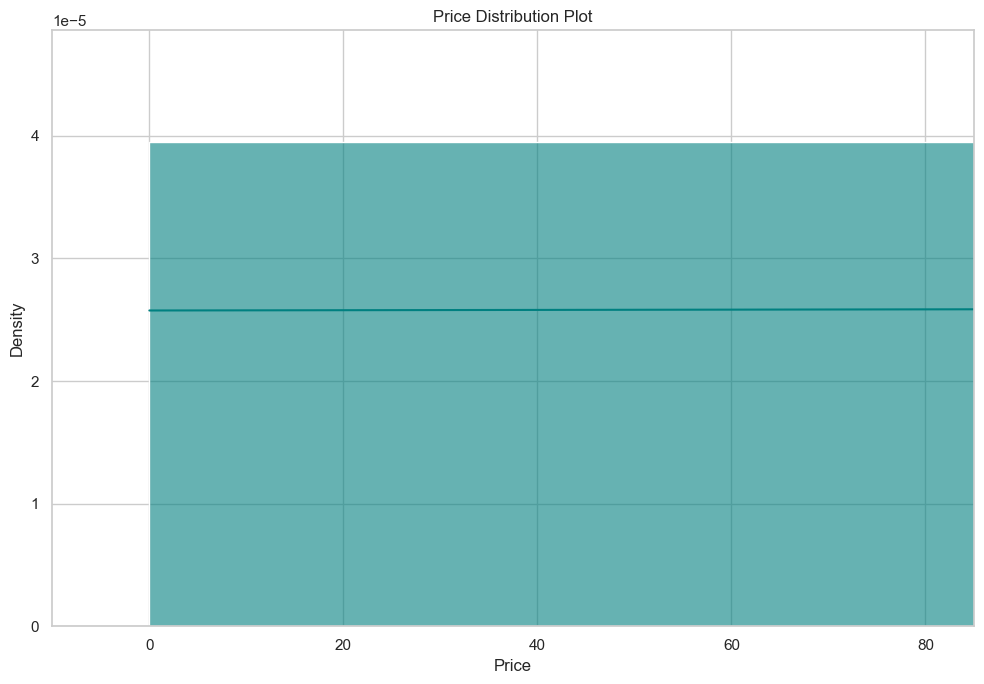

In [317]:
# Let's look at the data in price and distribution of the values

# Set the figure size
plt.figure(figsize=(10, 7))

# Create a histogram for the price distribution
sns.histplot(data_v3["price"], bins=20, kde=True, color='teal', stat='density', alpha=0.6)

# Set titles and labels
plt.title('Price Distribution Plot')
plt.xlabel('Price')
plt.xlim(-10, 85)

# Show the plot
plt.show()

In [318]:
# Calculate mean and median
mean_price = data_v3['price'].mean()
median_price = data_v3['price'].median()
f"{mean_price:.2f}, {median_price:.2f}"

'15837.45, 12000.00'

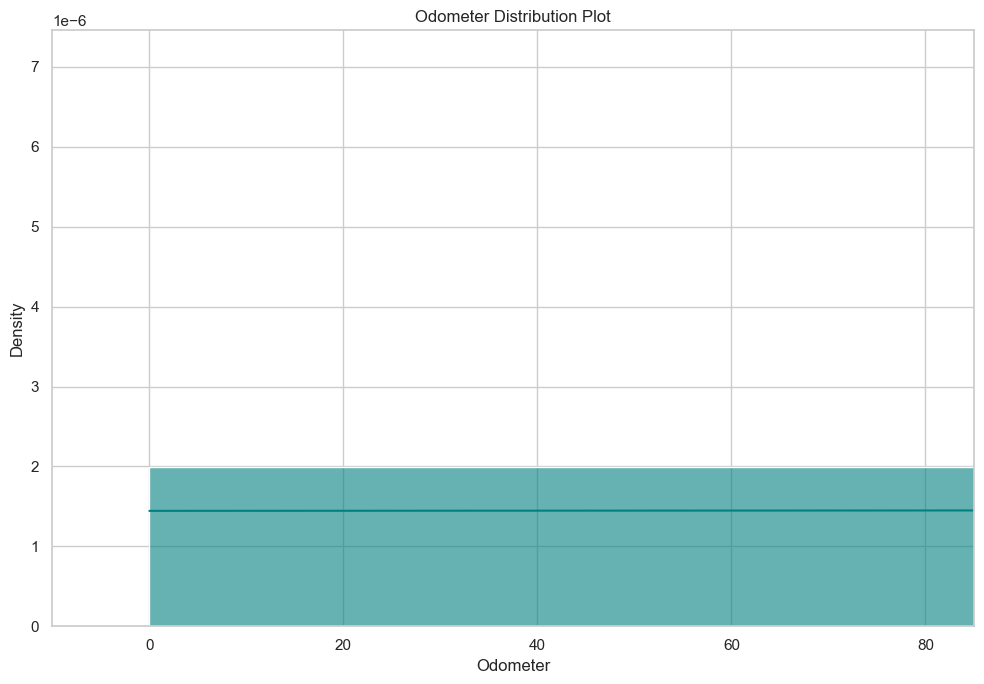

In [319]:
# Let's look at the data in odometer and distribution of the values

# Set the figure size
plt.figure(figsize=(10, 7))

# Create a histogram for the price distribution
sns.histplot(data_v3["odometer"], bins=20, kde=True, color='teal', stat='density', alpha=0.6)

# Set titles and labels
plt.title('Odometer Distribution Plot')
plt.xlabel('Odometer')
plt.xlim(-10, 85)

# Show the plot
plt.show()

In [320]:
# Calculate mean and median of odometer
mean_odomoter = data_v3['odometer'].mean()
median_odometer = data_v3['odometer'].median()
f"{mean_odomoter:.2f}, {median_odometer:.2f}"

'107399.09, 104000.00'

`These 2 distribution plots are not really helpful. Could be because of outliers or bad data so lets remove the records with zero for Odometer and Prices`

In [322]:
# lets remove the records with zero for Odometer and Prices
data_v3.drop(data_v3[data_v3['price'] == 0].index, inplace = True)
data_v3.drop(data_v3[data_v3['odometer'] == 0].index, inplace = True)
data_v3

price    year   manufacturer            model  condition    cylinders  \
215      4000  2002.0         toyota             echo  excellent  4 cylinders   
219      2500  1995.0            bmw             525i       fair  6 cylinders   
268      9000  2008.0          mazda       miata mx-5  excellent  4 cylinders   
337      8950  2011.0           ford            f-150  excellent  6 cylinders   
338      4000  1972.0  mercedes-benz             benz       fair  6 cylinders   
...       ...     ...            ...              ...        ...          ...   
426785  23495  2015.0           ford     f150 xlt 4x4   like new  8 cylinders   
426788  12995  2016.0      chevrolet         cruze lt   like new  4 cylinders   
426792  32999  2014.0           ford        f350, xlt  excellent  8 cylinders   
426793  15999  2018.0      chevrolet        cruze, lt  excellent  4 cylinders   
426833   6800  1997.0         jaguar  xk8 convertible       good  8 cylinders   

          fuel  odometer title_status transmission drive       size  \
215        gas  155000.0        clean    automatic   fwd    compact   
219        gas  110661.0        clean    automatic   rwd   mid-size   
268        gas   56700.0        clean    automatic   rwd    compact   
337        gas  164000.0        clean    automatic   fwd  full-size   
338        gas   88100.0        clean    automatic   rwd  full-size   
...        ...       ...          ...          ...   ...        ...   
426785     gas  146795.0        clean    automatic   4wd  full-size   
426788     gas   61127.0        clean    automatic   fwd    compact   
426792  diesel  154642.0        clean    automatic   4wd  full-size   
426793     gas   36465.0        clean    automatic   fwd   mid-size   
426833     gas   69550.0        clean    automatic   rwd    compact   

               type paint_color state  
215           sedan        blue    al  
219           sedan       white    al  
268     convertible       white    al  
337           truck       white    al  
338           coupe      silver    al  
...             ...         ...   ...  
426785        truck       black    wy  
426788        sedan      silver    wy  
426792       pickup       brown    wy  
426793        sedan       black    wy  
426833  convertible       white    wy  

[32432 rows x 15 columns]

In [323]:
# lets check on features with zero values
data_v3.eq(0).any()

price           False
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer        False
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool


**Lets look at different plots of the odometer and price to see the distribution of data**

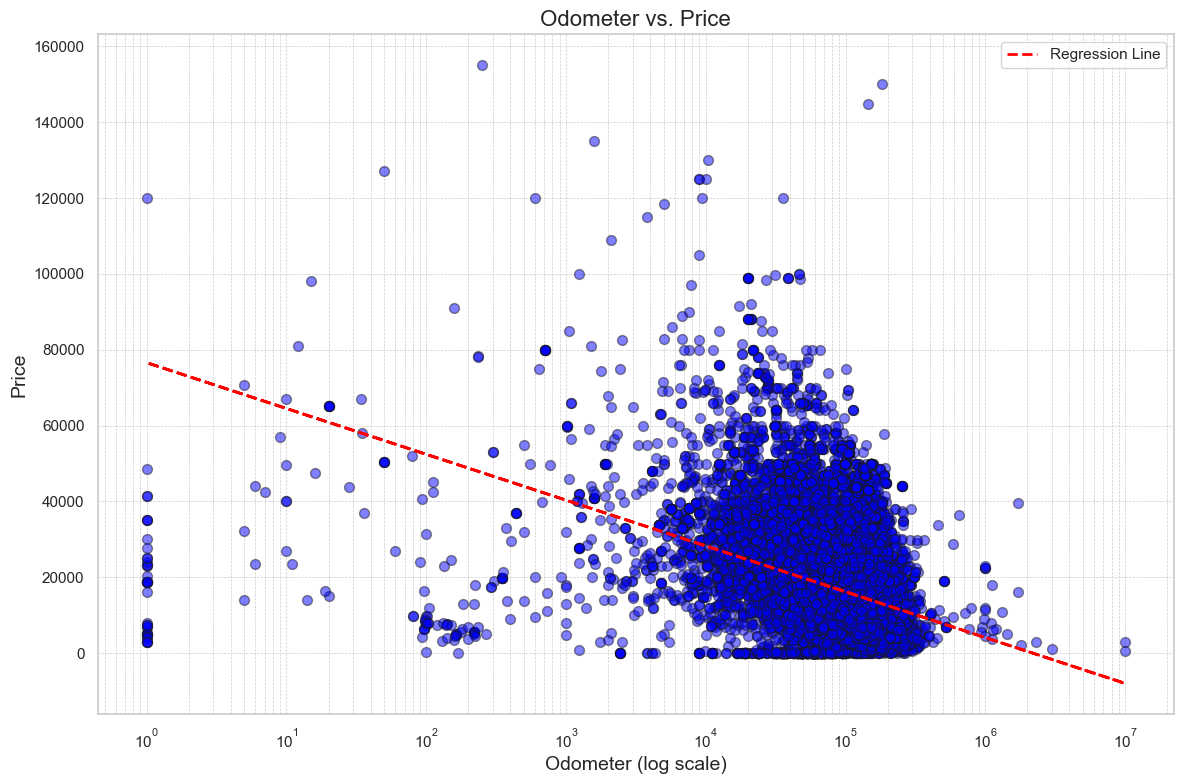

In [325]:
# Lets look at different plots of the odometer and price to see the distribution of data
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
plt.xscale("log")  # Set x-axis to logarithmic scale
ax.scatter(data_v3['odometer'], data_v3['price'], color='blue', alpha=0.5, edgecolor='k', s=50)  

# Add a grid for better visualization
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Fit a regression line (optional)
z = np.polyfit(np.log(data_v3['odometer']), data_v3['price'], 1)  
p = np.poly1d(z)
ax.plot(data_v3['odometer'], p(np.log(data_v3['odometer'])), color='red', linestyle='--', linewidth=2, label='Regression Line')

# Set a title and labels
ax.set_title('Odometer vs. Price', fontsize=16)
ax.set_xlabel('Odometer (log scale)', fontsize=14)
ax.set_ylabel('Price', fontsize=14)

# Add a legend
ax.legend()

# Show the plot
plt.show()

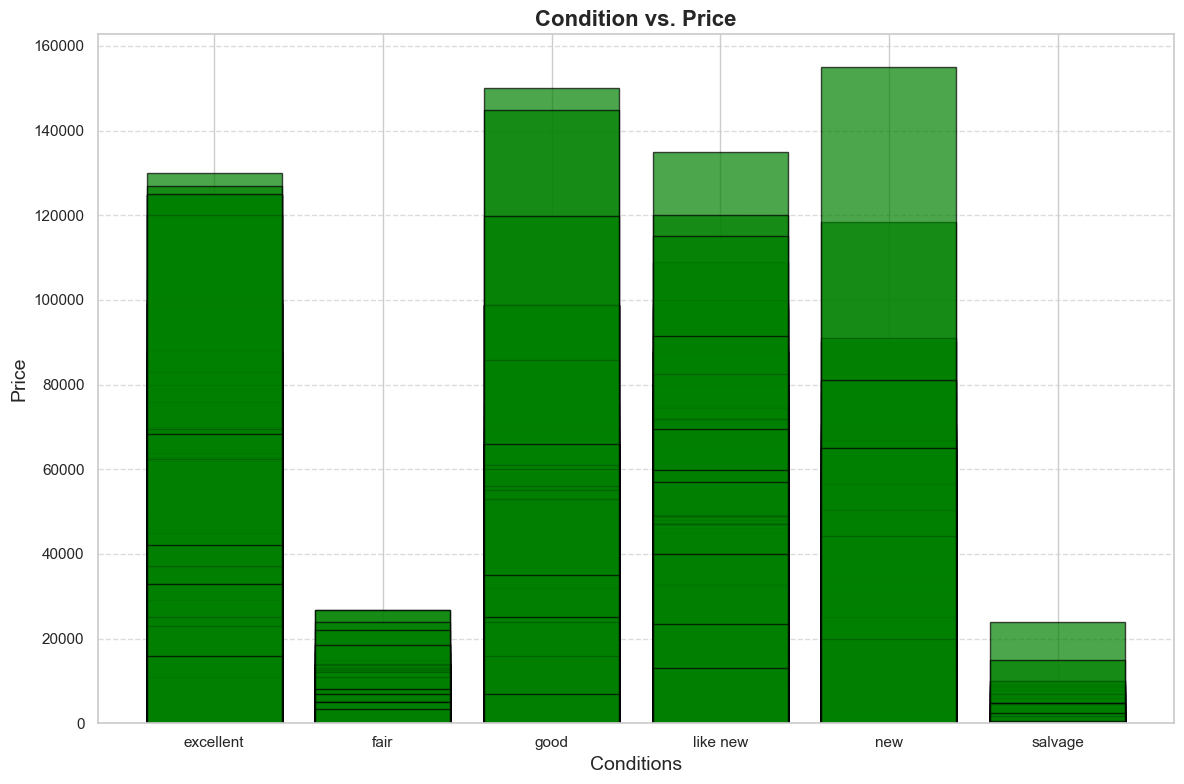

In [326]:
#lets look at the plot of vehicle condition and price
fig, ax = plt.subplots(figsize=(12, 8))

# Create a bar plot with color and edge color
bars = ax.bar(data_v3["condition"], data_v3["price"], color='green', edgecolor='black', alpha=0.7)

# Set a title and labels
ax.set_title('Condition vs. Price', fontsize=16, fontweight='bold')
ax.set_xlabel('Conditions', fontsize=14)
ax.set_ylabel('Price', fontsize=14)

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  
plt.show()

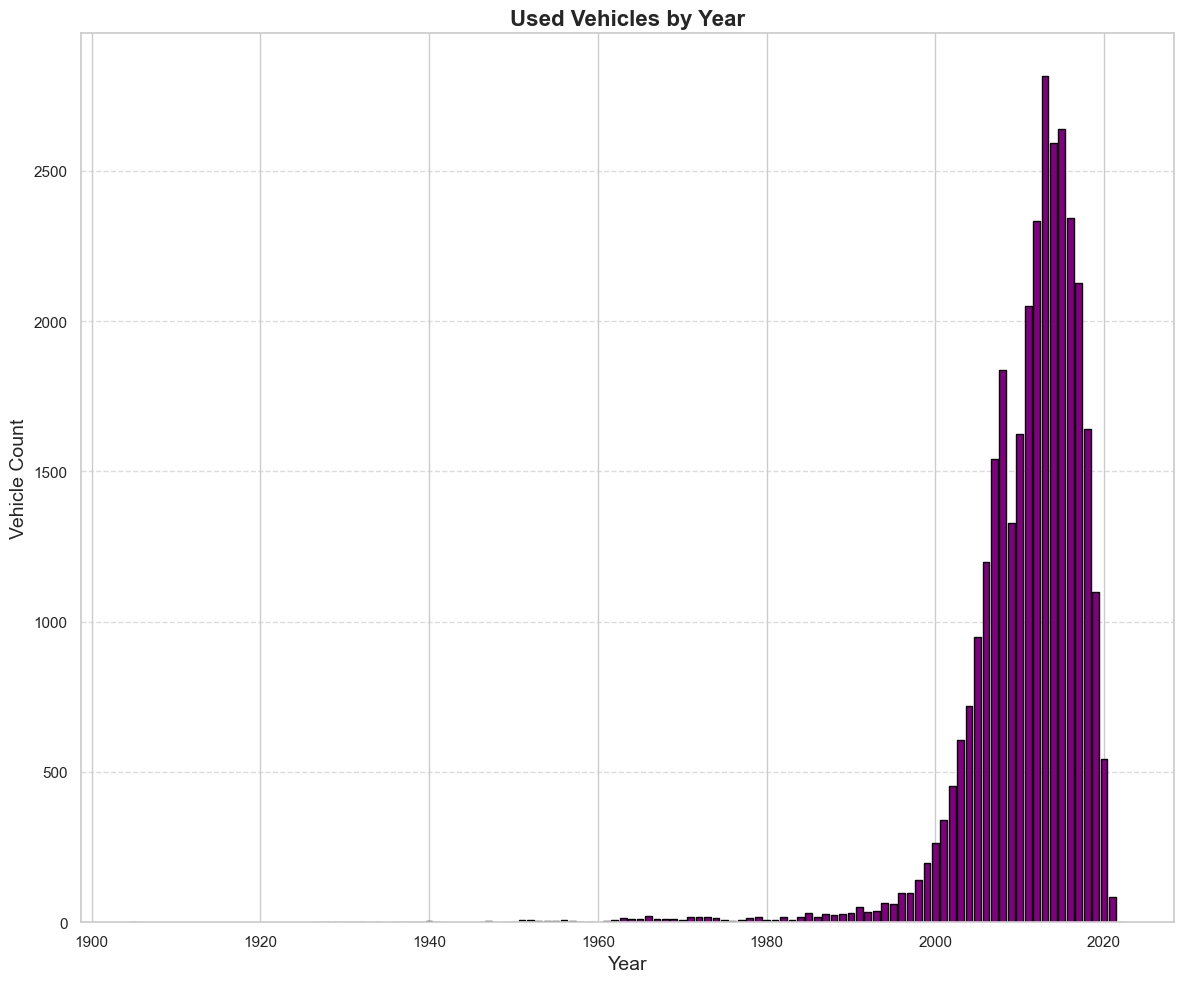

In [327]:
# Count the number of used vehicles by year
vehicle_counts = data_v3['year'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.bar(vehicle_counts.index, vehicle_counts.values, color='purple', edgecolor='black')

# Adding Title to the Plot
ax.set_title("Used Vehicles by Year", fontsize=16, fontweight='bold')

# Setting the X and Y labels
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Vehicle Count", fontsize=14)

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()  
plt.show()

`Observation from the plot shows there are fewer records from 1905 to 1990 so it is wise to take the records from 1991`

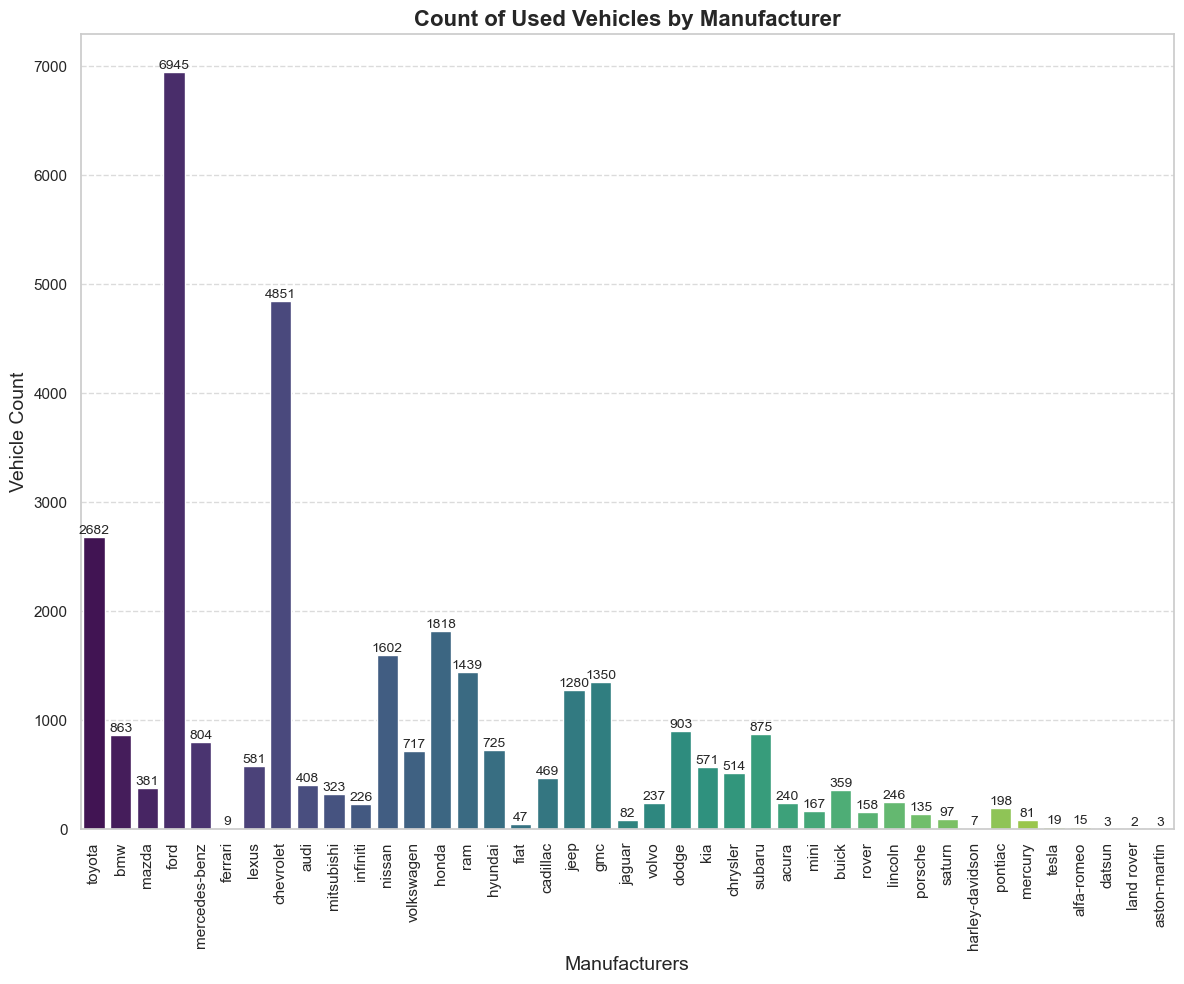

In [329]:
# Plot the number of used car counts by manufacturer

fig, ax = plt.subplots(figsize=(12, 10))

# Create a seaborn countplot with a color palette
ax = sns.countplot(x='manufacturer', data=data_v3, ax=ax, palette='viridis')

# Adding Title to the Plot with improved font size and weight
ax.set_title("Count of Used Vehicles by Manufacturer", fontsize=16, fontweight='bold')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=90)

ax.set_xlabel("Manufacturers", fontsize=14)
ax.set_ylabel("Vehicle Count", fontsize=14)

# Add data labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()  
plt.show()

`We can see that Ford, Chevrolet and Toyota are the top 3 manufacturers`

**Let us plot some pie charts to visualize the number of used cars based on car features**

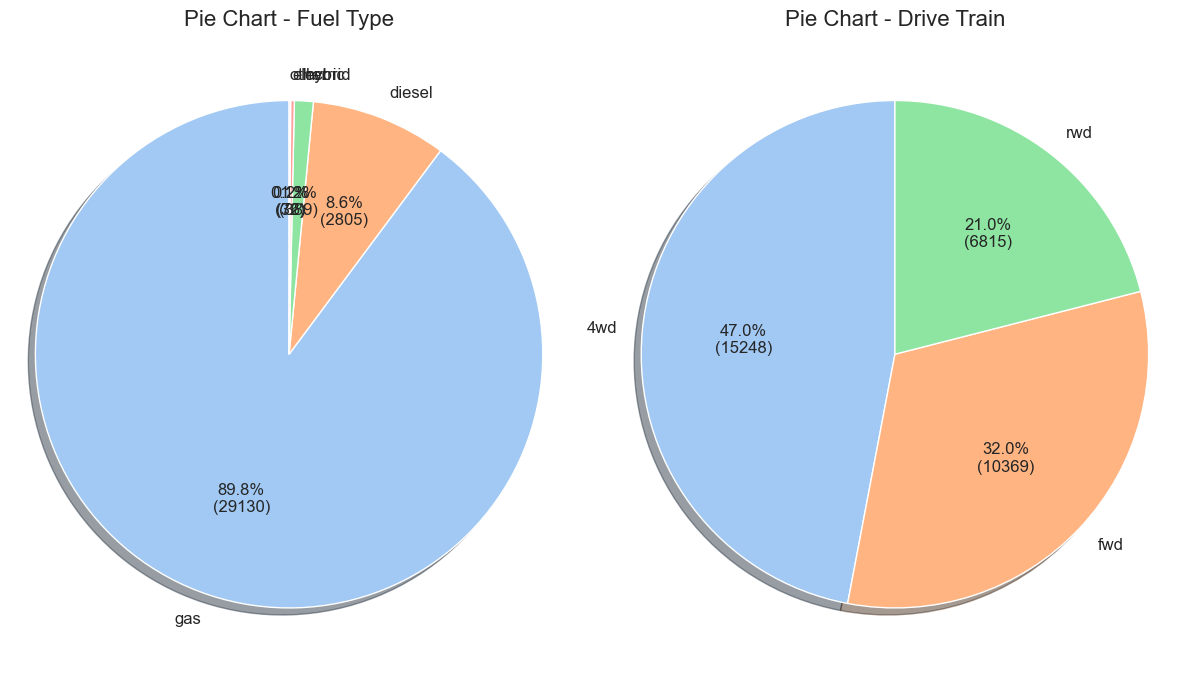

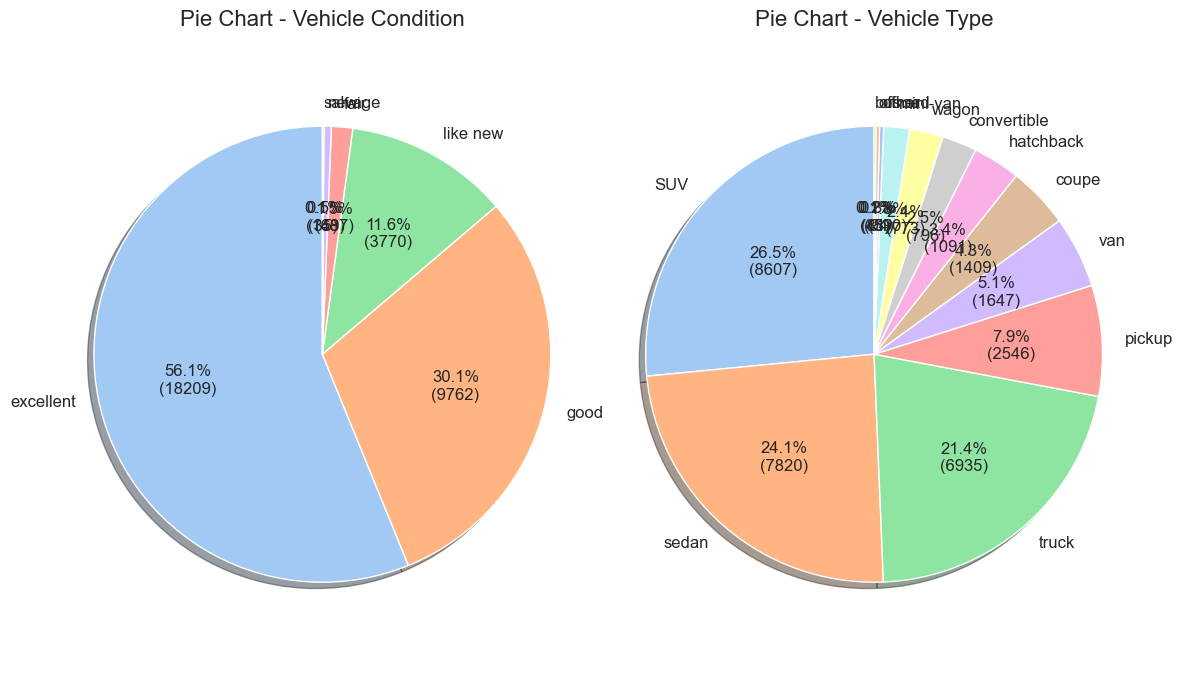

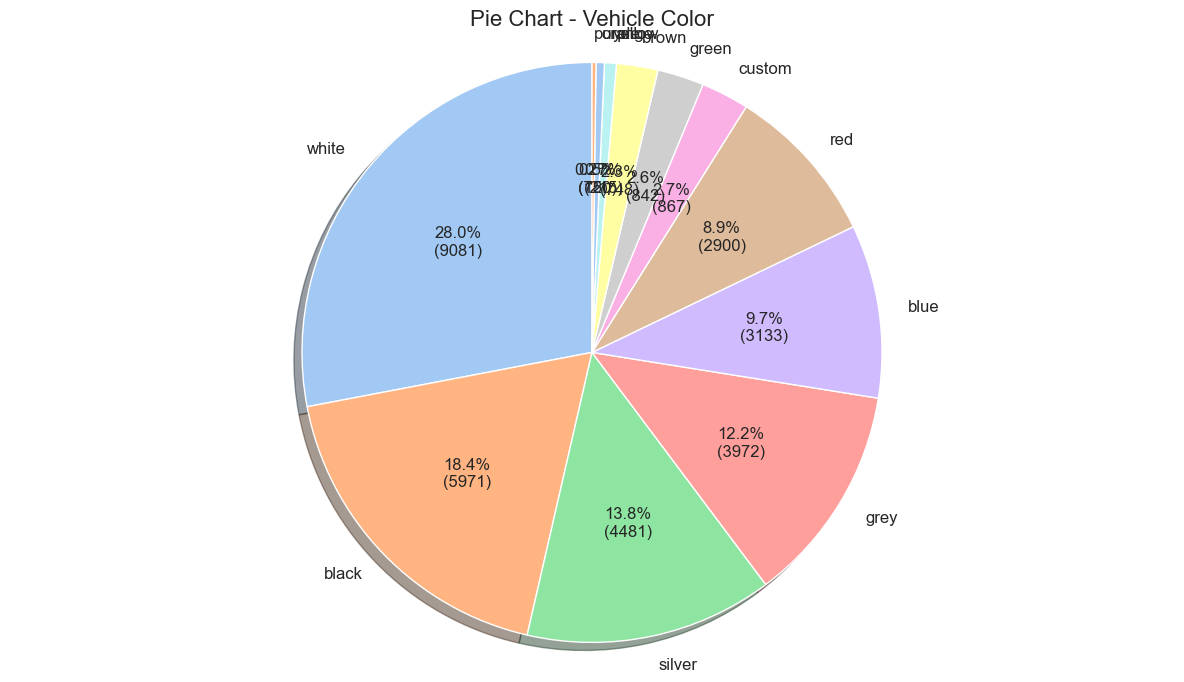

In [332]:

# Function to format the percentage display on the pie chart
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot each pie chart in a separate subplot
# Pie Chart for Fuel Type
ax1.set_title('Pie Chart - Fuel Type', fontsize=16)
s_fuel = data_v3['fuel'].value_counts()
ax1.pie(s_fuel, labels=s_fuel.index, autopct=autopct_format(s_fuel), startangle=90, 
         colors=sns.color_palette('pastel'), shadow=True, textprops={'fontsize': 12})

ax1.axis('equal')  

# Pie Chart for Drive Train
ax2.set_title('Pie Chart - Drive Train', fontsize=16)
s_drive = data_v3['drive'].value_counts()
ax2.pie(s_drive, labels=s_drive.index, autopct=autopct_format(s_drive), startangle=90, 
         colors=sns.color_palette('pastel'), shadow=True, textprops={'fontsize': 12})

ax2.axis('equal')  


# create a figure with two subplots one each for condition and Vehicle type
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,7))

# Pie Chart for Vehicle condition
ax3.set_title('Pie Chart - Vehicle Condition', fontsize=16)
s_condition = data_v3['condition'].value_counts()
ax3.pie(s_condition,labels = s_condition.index,  autopct=autopct_format(s_condition), startangle=90, 
         colors=sns.color_palette('pastel'), shadow=True, textprops={'fontsize': 12})

ax3.axis('equal')  

# Pie Chart for Vehicle Type
ax4.set_title('Pie Chart - Vehicle Type', fontsize=16)
s_vehicletype = data_v3['type'].value_counts()
ax4.pie(s_vehicletype,labels = s_vehicletype.index, autopct=autopct_format(s_vehicletype), startangle=90, 
         colors=sns.color_palette('pastel'), shadow=True, textprops={'fontsize': 12})


ax4.axis('equal')  

# Pie Chart for Vehicle color
fig, ax5 = plt.subplots(figsize=(12,7))

ax5.set_title('Pie Chart - Vehicle Color', fontsize=16)
s_paintcolor = data_v3['paint_color'].value_counts()
ax5.pie(s_paintcolor,labels = s_paintcolor.index, autopct=autopct_format(s_paintcolor), startangle=90, 
         colors=sns.color_palette('pastel'), shadow=True, textprops={'fontsize': 12})

ax5.axis('equal')  

plt.tight_layout()  
plt.show()

**In the above plots we can see how many number of used cars for the selected car features**

In [334]:
#the Correlation after some data manipulation
data_v3.select_dtypes(include=['number']).corr()

price      year  odometer
price     1.000000  0.317258 -0.233163
year      0.317258  1.000000 -0.212234
odometer -0.233163 -0.212234  1.000000

In [335]:
#The correlation between price, odometer and year is poor with just the year has a positive value

Our dataset is clean with no missing values, lets explore the data for features that make no meaningful impact on the price and try to remove them for better modeling

Lets review the uniqueness of the following features state, paint_color, manufacturer, model, cylinders,
type, transmission and title_status

In [338]:
data_v3['state'].value_counts()

state
fl    3395
ca    3296
ny    1722
tx    1295
mi    1222
wi    1111
nc    1091
oh    1033
ia    1030
pa     999
or     984
va     978
tn     863
mn     792
nj     789
co     759
vt     676
ma     655
il     634
id     604
az     599
ks     599
in     565
ky     543
ok     500
sc     449
al     419
ak     403
mo     381
mt     348
wa     312
ct     298
ga     270
nm     238
ri     230
nv     221
hi     207
me     197
nh     192
dc     182
md     161
ut     153
sd     149
ar     145
ne     134
nd     133
la     130
de     109
wv      88
wy      87
ms      62
Name: count, dtype: int64

In [339]:
data_v3['paint_color'].value_counts()

paint_color
white     9081
black     5971
silver    4481
grey      3972
blue      3133
red       2900
custom     867
green      842
brown      748
yellow     215
orange     150
purple      72
Name: count, dtype: int64

In [340]:
data_v3['manufacturer'].value_counts()

manufacturer
ford               6945
chevrolet          4851
toyota             2682
honda              1818
nissan             1602
ram                1439
gmc                1350
jeep               1280
dodge               903
subaru              875
bmw                 863
mercedes-benz       804
hyundai             725
volkswagen          717
lexus               581
kia                 571
chrysler            514
cadillac            469
audi                408
mazda               381
buick               359
mitsubishi          323
lincoln             246
acura               240
volvo               237
infiniti            226
pontiac             198
mini                167
rover               158
porsche             135
saturn               97
jaguar               82
mercury              81
fiat                 47
tesla                19
alfa-romeo           15
ferrari               9
harley-davidson       7
datsun                3
aston-martin          3
land rover            2
Nam

In [341]:
data_v3['model'].value_counts()


model
f-150                     812
silverado 1500            771
1500                      408
2500                      267
silverado 2500hd          255
                         ... 
rondo ex                    1
sentra special edition      1
2500 st                     1
g37 x awd                   1
cruze, 2lt                  1
Name: count, Length: 4943, dtype: int64

In [342]:
data_v3['cylinders'].value_counts()


cylinders
6 cylinders     10773
4 cylinders     10655
8 cylinders     10017
10 cylinders      548
5 cylinders       270
other              92
3 cylinders        66
12 cylinders       11
Name: count, dtype: int64

In [343]:
data_v3['type'].value_counts()


type
SUV            8607
sedan          7820
truck          6935
pickup         2546
van            1647
coupe          1409
hatchback      1091
convertible     796
wagon           773
mini-van        590
other            94
offroad          81
bus              43
Name: count, dtype: int64

In [344]:
data_v3['transmission'].value_counts()


transmission
automatic    30093
manual        1645
other          694
Name: count, dtype: int64

In [345]:
data_v3['title_status'].value_counts()


title_status
clean         31258
rebuilt         786
salvage         239
lien            134
missing          14
parts only        1
Name: count, dtype: int64

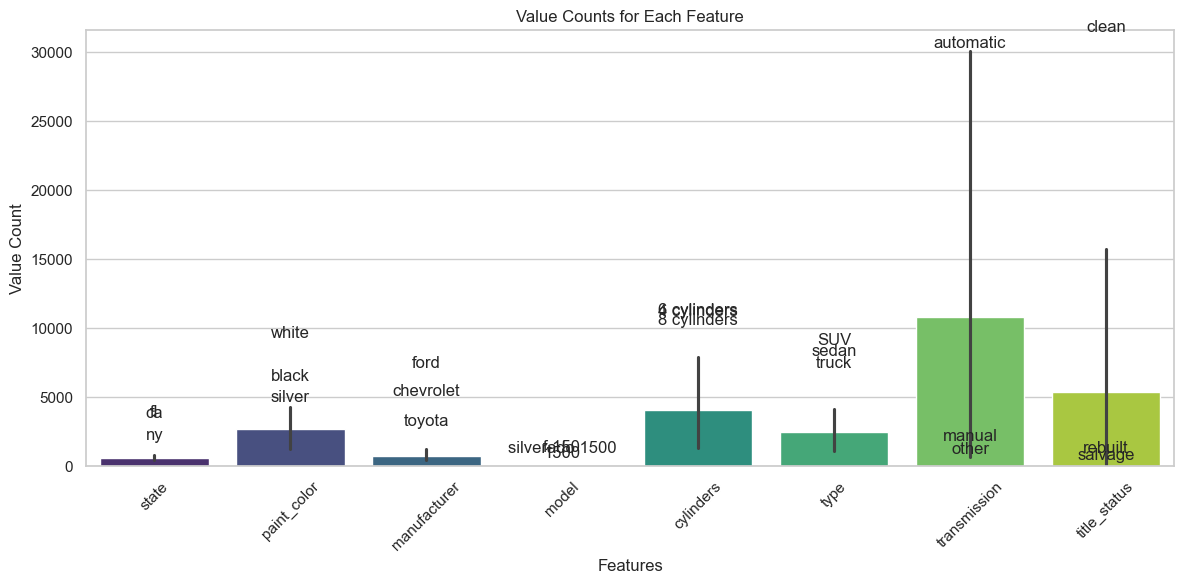

In [346]:
#Let us try to visualize this
# Create an empty DataFrame to hold the counts
value_counts_df = pd.DataFrame()

# Loop through each feature and get the value counts
for feature in ['state', 'paint_color', 'manufacturer', 'model', 'cylinders', 'type', 'transmission', 'title_status']:
    counts = data_v3[feature].value_counts().reset_index()
    counts.columns = [feature, 'value_count']  # Rename columns
    counts['Feature'] = feature  # Add a column for the feature name
    value_counts_df = pd.concat([value_counts_df, counts], ignore_index=True)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=value_counts_df, x='Feature', y='value_count', hue='Feature', palette='viridis')
plt.title('Value Counts for Each Feature')
plt.xlabel('Features')
plt.ylabel('Value Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add top 3 data value labels for each feature
for feature in value_counts_df['Feature'].unique():
    feature_data = value_counts_df[value_counts_df['Feature'] == feature]
    top_3 = feature_data.nlargest(3, 'value_count')  # Get top 3 counts
    for index, row in top_3.iterrows():
        plt.text(row['Feature'], row['value_count'], row[feature], 
                 ha='center', va='bottom')  # Add text label above the bar

plt.show()

##### Top 3 values shows these columns may not have major impacts on the price in this dataset even though the model and manufacturer in genral will have impact on the price

When we look at these value counts for each feature above we can safely drop these features becuase:
- state has numerous options and this feature should not have a big impact on price even in real world
- paint_color has numerous unique values with white color as high count
- manufacturer is varied with ford with the high number of vehicles
- model has 4943vlooks like has many incorrect and should not have a big impact on price
- cylinders 4,6,8 has equal count almost and may not have a big impact on price
- type should not have a big impact on price with few counts of types
- transmission is mainly automatic so we can drop
- title_status can be dropped, we have condition field

In [348]:
# Remove the above features
data_v3.drop(['state', 'paint_color', 'manufacturer', 'model', 'cylinders', 'type', 'transmission', 'title_status'], axis=1,  inplace=True)
data_v3.head(5)

price    year  condition fuel  odometer drive       size
215   4000  2002.0  excellent  gas  155000.0   fwd    compact
219   2500  1995.0       fair  gas  110661.0   rwd   mid-size
268   9000  2008.0  excellent  gas   56700.0   rwd    compact
337   8950  2011.0  excellent  gas  164000.0   fwd  full-size
338   4000  1972.0       fair  gas   88100.0   rwd  full-size

In [349]:
# Let's reviwed the unique values for the features that we are planning to keep for the model
data_v3['condition'].value_counts()

condition
excellent    18209
good          9762
like new      3770
fair           487
new            169
salvage         35
Name: count, dtype: int64

In [350]:
data_v3['fuel'].value_counts()

fuel
gas         29130
diesel       2805
hybrid        389
electric       76
other          32
Name: count, dtype: int64

In [351]:
data_v3['size'].value_counts()

size
full-size      19118
mid-size        8920
compact         3809
sub-compact      585
Name: count, dtype: int64

In [352]:
data_v3['drive'].value_counts()

drive
4wd    15248
fwd    10369
rwd     6815
Name: count, dtype: int64

These features do not have that many unique values with the number of unique values ranging from 3 to 6
We may decide to add "paint_color" depending on the model and results of the linear regression models

In [354]:
#Lets create categorical variables 
data_model = pd.get_dummies(data_v3, columns=["condition", "fuel", "size", "drive"])
data_model.head()

price    year  odometer  condition_excellent  condition_fair  \
215   4000  2002.0  155000.0                 True           False   
219   2500  1995.0  110661.0                False            True   
268   9000  2008.0   56700.0                 True           False   
337   8950  2011.0  164000.0                 True           False   
338   4000  1972.0   88100.0                False            True   

     condition_good  condition_like new  condition_new  condition_salvage  \
215           False               False          False              False   
219           False               False          False              False   
268           False               False          False              False   
337           False               False          False              False   
338           False               False          False              False   

     fuel_diesel  ...  fuel_gas  fuel_hybrid  fuel_other  size_compact  \
215        False  ...      True        False       False          True   
219        False  ...      True        False       False         False   
268        False  ...      True        False       False          True   
337        False  ...      True        False       False         False   
338        False  ...      True        False       False         False   

     size_full-size  size_mid-size  size_sub-compact  drive_4wd  drive_fwd  \
215           False          False             False      False       True   
219           False           True             False      False      False   
268           False          False             False      False      False   
337            True          False             False      False       True   
338            True          False             False      False      False   

     drive_rwd  
215      False  
219       True  
268       True  
337      False  
338       True  

[5 rows x 21 columns]

In [355]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32432 entries, 215 to 426833
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                32432 non-null  int64  
 1   year                 32432 non-null  float64
 2   odometer             32432 non-null  float64
 3   condition_excellent  32432 non-null  bool   
 4   condition_fair       32432 non-null  bool   
 5   condition_good       32432 non-null  bool   
 6   condition_like new   32432 non-null  bool   
 7   condition_new        32432 non-null  bool   
 8   condition_salvage    32432 non-null  bool   
 9   fuel_diesel          32432 non-null  bool   
 10  fuel_electric        32432 non-null  bool   
 11  fuel_gas             32432 non-null  bool   
 12  fuel_hybrid          32432 non-null  bool   
 13  fuel_other           32432 non-null  bool   
 14  size_compact         32432 non-null  bool   
 15  size_full-size       32432 non-null  b

In [356]:
#Let's look at the correlation for the model dataset
data_model.corr()

price      year  odometer  condition_excellent  \
price                1.000000  0.317258 -0.233163            -0.024179   
year                 0.317258  1.000000 -0.212234             0.081343   
odometer            -0.233163 -0.212234  1.000000            -0.033959   
condition_excellent -0.024179  0.081343 -0.033959             1.000000   
condition_fair      -0.117517 -0.166194  0.117778            -0.139705   
condition_good      -0.055432 -0.144118  0.091095            -0.742491   
condition_like new   0.147255  0.134789 -0.117267            -0.410360   
condition_new        0.076584  0.044497 -0.036769            -0.081891   
condition_salvage   -0.030312 -0.013736  0.029717            -0.037190   
fuel_diesel          0.420564  0.025427  0.046102            -0.032248   
fuel_electric        0.020550  0.030977 -0.028453            -0.013713   
fuel_gas            -0.379040 -0.034400 -0.037938             0.027311   
fuel_hybrid         -0.038859  0.020805 -0.003167             0.011756   
fuel_other          -0.011298 -0.016149  0.007467             0.006004   
size_compact        -0.196132  0.013967 -0.056646             0.066284   
size_full-size       0.307108  0.005844  0.066543            -0.090548   
size_mid-size       -0.178640 -0.012437 -0.030012             0.039500   
size_sub-compact    -0.061325 -0.013661 -0.008237             0.041811   
drive_4wd            0.294039  0.134664  0.017157             0.047806   
drive_fwd           -0.372592  0.038940 -0.008741             0.031752   
drive_rwd            0.066291 -0.209552 -0.011012            -0.094915   

                     condition_fair  condition_good  condition_like new  \
price                     -0.117517       -0.055432            0.147255   
year                      -0.166194       -0.144118            0.134789   
odometer                   0.117778        0.091095           -0.117267   
condition_excellent       -0.139705       -0.742491           -0.410360   
condition_fair             1.000000       -0.081023           -0.044780   
condition_good            -0.081023        1.000000           -0.237991   
condition_like new        -0.044780       -0.237991            1.000000   
condition_new             -0.008936       -0.047494           -0.026249   
condition_salvage         -0.004058       -0.021569           -0.011921   
fuel_diesel               -0.017246        0.048475           -0.011315   
fuel_electric             -0.005984       -0.015120            0.046090   
fuel_gas                   0.015580       -0.031143           -0.002916   
fuel_hybrid                0.000370       -0.030312            0.018365   
fuel_other                 0.012270       -0.005635           -0.005270   
size_compact               0.011658       -0.078194            0.001861   
size_full-size            -0.021170        0.110753           -0.007106   
size_mid-size              0.017066       -0.056740            0.013166   
size_sub-compact          -0.007209       -0.029843           -0.022409   
drive_4wd                 -0.023857       -0.027426           -0.027076   
drive_fwd                  0.013753       -0.060258            0.029430   
drive_rwd                  0.013483        0.102579           -0.000519   

                     condition_new  condition_salvage  fuel_diesel  ...  \
price                     0.076584          -0.030312     0.420564  ...   
year                      0.044497          -0.013736     0.025427  ...   
odometer                 -0.036769           0.029717     0.046102  ...   
condition_excellent      -0.081891          -0.037190    -0.032248  ...   
condition_fair           -0.008936          -0.004058    -0.017246  ...   
condition_good           -0.047494          -0.021569     0.048475  ...   
condition_like new       -0.026249          -0.011921    -0.011315  ...   
condition_new             1.000000          -0.002379    -0.003987  ...   
condition_salvage        -0.002379           1.000000    -0.006773  .

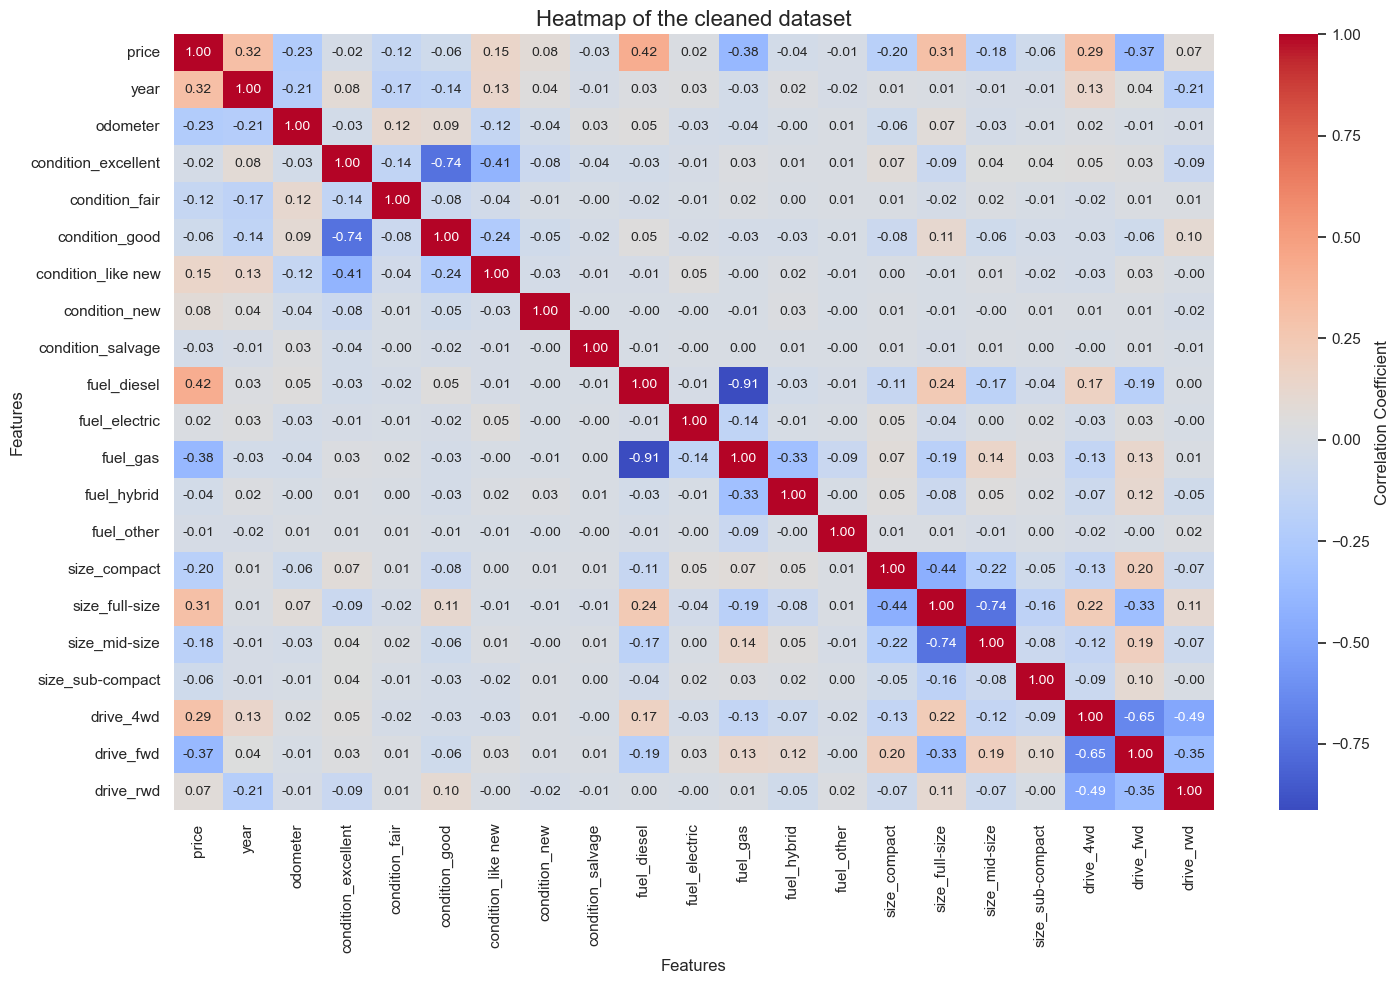

In [357]:
# plot the heatmap for the model dataset

fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams["figure.autolayout"] = True

# Create seaborn heatmap with improved color palette and annotation size
ax = sns.heatmap(data_model.corr(), annot=True, fmt=".2f", cmap='coolwarm', 
                 annot_kws={"size": 10}, cbar_kws={"label": "Correlation Coefficient"})

# Adding Title to the Plot
ax.set_title("Heatmap of the cleaned dataset", fontsize=16)
ax.set_xlabel("Features", fontsize=12)  # X-axis label
ax.set_ylabel("Features", fontsize=12)  # Y-axis label

# Full screen toggle for better visibility
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()

plt.show()

##### Corrrelation Observations
There is a notable correlation between fuel_gas and fuel_diesel, but it isn't linked to price. After categorizing the variables, the strongest correlation with price is found with fuel_diesel. 

When examining the price, most of the correlations are negative, with only a few positive ones: year, condition_like new, fuel_diesel, size_full-size, and drive_4wd. Among these, the strongest positive correlation with price is fuel_diesel. However, although these correlations are positive, none are strong enough (with values under 0.85) to warrant removal.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

ML Applications using Linear Regression that could be used to predict Vehicle Prices.

The model application will be created using the full set of features (i.e.,year, condition, fuel, odometer, drive and size) in the final dataset

In [361]:
# As a first step, split the data to training and test, 70/30 for training and test respectively
def split_data(data, target_column, test_size=0.3, random_state=0):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    - data: DataFrame containing the features and target variable.
    - target_column: The name of the target variable column.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.

    Returns:
    - X_train, X_test, y_train, y_test: Split datasets.
    """
    X = data.drop([target_column], axis=1)
    y = data[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train, X_test, y_train, y_test = split_data(data_model, 'price')

In [362]:
#Create a new model

# Step 1: Fit the model
model=LinearRegression(fit_intercept=False)
# With model created, let's fit the model using the manipulated datasets
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [363]:
# Step 2: Examine the estimated coefficients
coefficients = model.coef_
intercept = model.intercept_

# Display coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 4.46704324e+02 -3.09688337e-02 -1.54338713e+05 -1.58651264e+05
 -1.55233917e+05 -1.50690552e+05 -1.41934204e+05 -1.61738600e+05
 -1.72819894e+05 -1.83178464e+05 -1.88680426e+05 -1.87593282e+05
 -1.90315183e+05 -2.33513277e+05 -2.27308162e+05 -2.30570934e+05
 -2.31194877e+05 -3.05095947e+05 -3.12652620e+05 -3.04838683e+05]
Intercept: 0.0


In [364]:
# Get the coefficients
coefficients = []
for col, coef in zip(X_train.columns, model.coef_):
    coefficients.append((col, coef))

# Get the coefficients as a list of tuples (column name, coefficient)
coefficients = [(col, coef) for col, coef in zip(X_train.columns, model.coef_)]

coefficients

[('year', 446.70432446088745),
 ('odometer', -0.030968833659875017),
 ('condition_excellent', -154338.71260567982),
 ('condition_fair', -158651.263527352),
 ('condition_good', -155233.91745014954),
 ('condition_like new', -150690.5519275711),
 ('condition_new', -141934.2038388255),
 ('condition_salvage', -161738.59994306858),
 ('fuel_diesel', -172819.8938903951),
 ('fuel_electric', -183178.46426226012),
 ('fuel_gas', -188680.42586242835),
 ('fuel_hybrid', -187593.28213744066),
 ('fuel_other', -190315.18314012192),
 ('size_compact', -233513.27694948588),
 ('size_full-size', -227308.16170012904),
 ('size_mid-size', -230570.93408284071),
 ('size_sub-compact', -231194.87656018574),
 ('drive_4wd', -305095.9465458514),
 ('drive_fwd', -312652.62002822664),
 ('drive_rwd', -304838.6827184659)]

In [365]:
# Step 3: Make predictions for training set
train_predictions = model.predict(X_train)

# Display predictions
print("Training Predictions:", train_predictions)

Training Predictions: [18582.98161611  8207.71147576 16212.89413723 ...  7693.37587238
  4556.62711211 16546.25253369]


In [366]:
# Compute accuracy
accuracy = round(model.score(X_train, y_train) * 100, 2)

# Compute RMSE
rmse = round(np.sqrt(mean_squared_error(y_train, train_predictions)), 2)

# Print results
print("Accuracy: ", accuracy)
print("RMSE:     ", rmse)

Accuracy:  44.54
RMSE:      9846.1


The training model's score is relatively weak, at just 0.44. This could be attributed to poor or unrealistic data, such as odometer readings and price values that are set to 1.

In [368]:
# Using the model to make predictions of Price on the test set:
test_predictions=model.predict(X_test)

# Compute accuracy
accuracy = round(model.score(X_test, y_test) * 100, 2)

# Compute RMSE
rmse = round(np.sqrt(mean_squared_error(y_test, test_predictions)), 2)

# Print results
print("Accuracy: ", accuracy)
print("RMSE:     ", rmse)

Accuracy:  43.09
RMSE:      9941.12


**Lets plot to visualize how the model performed by plotting the actual vs predicted values**

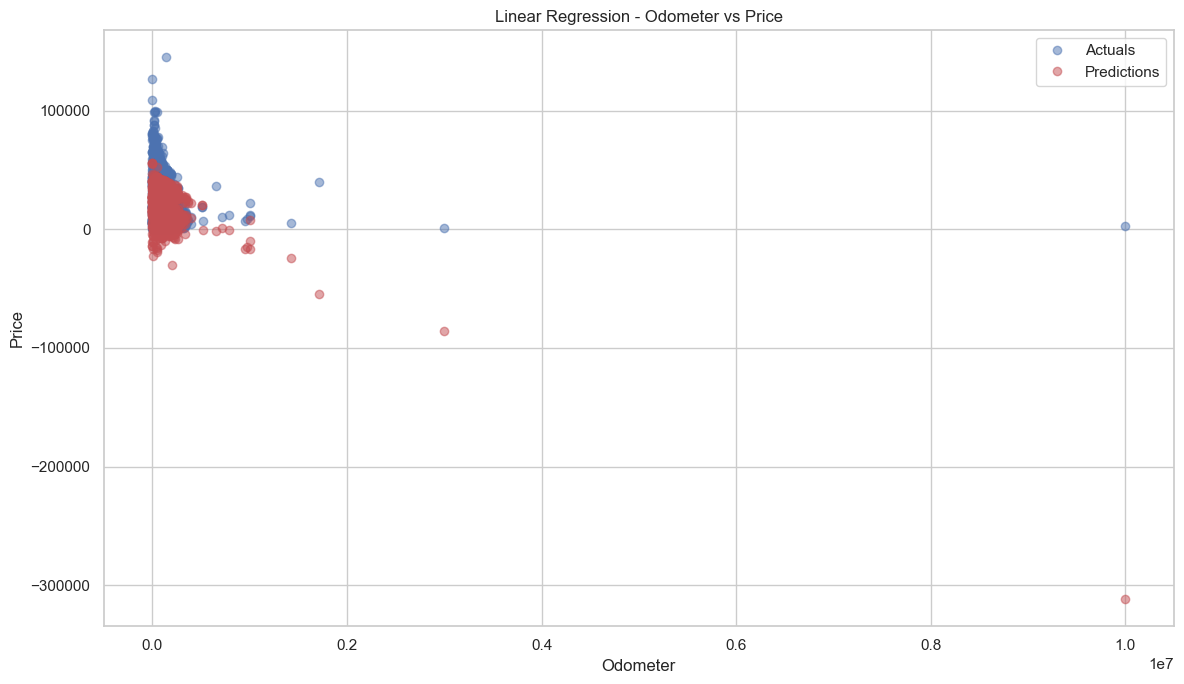

In [370]:
# Plotting actual vs predicted values
plt.figure(figsize=(12, 7))
plt.plot(X_test.odometer, y_test, 'ob', label='Actuals', alpha=0.5)
plt.plot(X_test.odometer, test_predictions, 'or', label='Predictions', alpha=0.5)
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.title('Linear Regression - Odometer vs Price')
plt.legend()
plt.show()

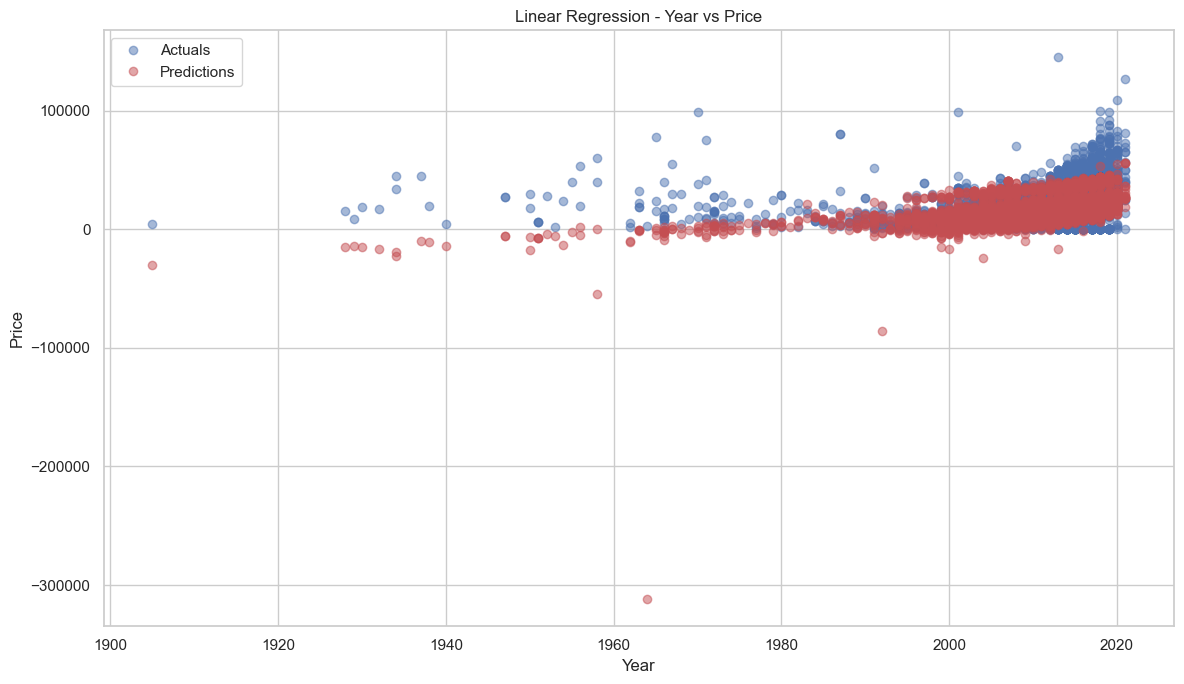

In [371]:
# Lets plot to visualize how the model performed by plotting the actual and predicted values
# Plotting actual vs predicted values
plt.figure(figsize=(12, 7))
plt.plot(X_test.year, y_test, 'ob', label='Actuals', alpha=0.5)
plt.plot(X_test.year, test_predictions, 'or', label='Predictions', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Linear Regression - Year vs Price')
plt.legend()
plt.show()

**As you can see both visualizations of the Linear regression results is not correct with negative predictions for Price**

In [373]:
# Check the correlation to see if the model tracks the relationship between independent and dependent features
np.corrcoef(y_test, test_predictions) [0][1]

0.6586628004709668

With a correlation coefficient of 0.65 and an accuracy of 43.09%, the results indicate that the predictions are not strongly correlated.

In [375]:
# Let us Predict using all input values as parameters

# First Example: New car with 100 miles, condition excellent, diesel engine, and four-wheel drive
new_car_with_all_strong_features = [[2022, 100, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]]
predicted_price_1 = model.predict(new_car_with_all_strong_features)
print("New car with 100 miles, condition excellent, diesel engine, and four-wheel drive: $", predicted_price_1[0])

# Second Example: New car with 100 miles, condition good, electric engine, and front-wheel drive
new_ev_car_with_some_features = [[2022, 100, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]]
predicted_price_2 = model.predict(new_ev_car_with_some_features)
print("New car with 100 miles, condition good, electric engine, and front-wheel drive: $", predicted_price_2[0])

# Third Example: Used car with 50,000 miles, condition fair, gasoline engine, and rear-wheel drive
used_car_with_fair_condition = [[2015, 50000, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]
predicted_price_3 = model.predict(used_car_with_fair_condition)
print("Used car with 50,000 miles, condition fair, gasoline engine, and rear-wheel drive: $", predicted_price_3[0])

# Fourth Example: New car with 10 miles, condition excellent, hybrid engine, and all-wheel drive
new_hybrid_car = [[2022, 10, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]]
predicted_price_4 = model.predict(new_hybrid_car)
print("New car with 10 miles, condition excellent, hybrid engine, and all-wheel drive: $", predicted_price_4[0])

New car with 100 miles, condition excellent, diesel engine, and four-wheel drive: $ -98263.87140433246
New car with 100 miles, condition good, electric engine, and front-wheel drive: $ 29013.338858291274
Used car with 50,000 miles, condition fair, gasoline engine, and rear-wheel drive: $ 265518.2886070472
New car with 10 miles, condition excellent, hybrid engine, and all-wheel drive: $ 78206.97035920079


Observations: These results suggest that the model is predicting highly inconsistent and unrealistic values for car prices based on different features. Issue with outliers and bad data

1. New car with 100 miles, excellent condition, diesel engine, and four-wheel drive: $-98,263.87  
   This is an unrealistic and negative price, which indicates that the model is not handling certain feature combinations well, possibly due to issues with data quality or the model’s inability to correctly interpret the relationship between features and price.

2. New car with 100 miles, good condition, electric engine, and front-wheel drive: $29,013.34 
   While this price is positive, it still seems low for a new car. It suggests that the model might be underestimating the value of new cars with certain features.

3. Used car with 50,000 miles, fair condition, gasoline engine, and rear-wheel drive: $265,518.29 
   This is an unusually high price for a used car with 50,000 miles and fair condition, suggesting overestimation. The model may be overvaluing some car features or not properly accounting for depreciation.

4. New car with 10 miles, excellent condition, hybrid engine, and all-wheel drive: $78,206.97 
   This value seems more reasonable for a new car, but it's still unclear if it's too high or too low compared to typical market prices.


   This indicates that a particular selection or feature set was removed from the analysis, possibly due to issues with the data or the model’s inability to handle certain combinations.

Overall, the model is likely overfitting, misinterpreting the relationships between features and price, and producing unrealistic or inconsistent predictions. These results suggest that further tuning, feature engineering, or data cleaning is needed to improve the model's performance and reliability.

#### Start running the Regression Model using a selected number of features only
``First Model`` application will be created using `odometer` and `year` in the dataset

In [378]:
# Prepare data
X1 = data_model[['odometer', 'year']]
y1 = data_model['price']

# Split the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)

# Fit the model
first_model = LinearRegression(fit_intercept=False)
first_model.fit(X1_train, y1_train)

# Print coefficients and intercept
print("Coefficient of the model: ", first_model.coef_)
print("Intercept of the model: ", first_model.intercept_)

# Get coefficients for each feature
coefficients = [(col, coef) for col, coef in zip(X1_train.columns, first_model.coef_)]
print("Feature coefficients: ", coefficients)

# Predictions on training set
train1_predictions = first_model.predict(X1_train)

# Compute and print accuracy and RMSE for training set
train1_score = first_model.score(X1_train, y1_train)
print("Training Accuracy: ", round(train1_score * 100, 2))
print("Training RMSE:     ", round(np.sqrt(mean_squared_error(y1_train, train1_predictions)), 2))

# Predictions on test set
test1_predictions = first_model.predict(X1_test)

# Compute and print accuracy and RMSE for test set
test1_score = first_model.score(X1_test, y1_test)
print("Test Accuracy: ", round(test1_score * 100, 2))
print("Test RMSE:     ", round(np.sqrt(mean_squared_error(y1_test, test1_predictions)), 2))

Coefficient of the model:  [-0.03699603 10.44305147]
Intercept of the model:  0.0
Feature coefficients:  [('odometer', -0.0369960341290061), ('year', 10.443051473587191)]
Training Accuracy:  6.94
Training RMSE:      12753.69
Test Accuracy:  1.92
Test RMSE:      13050.18


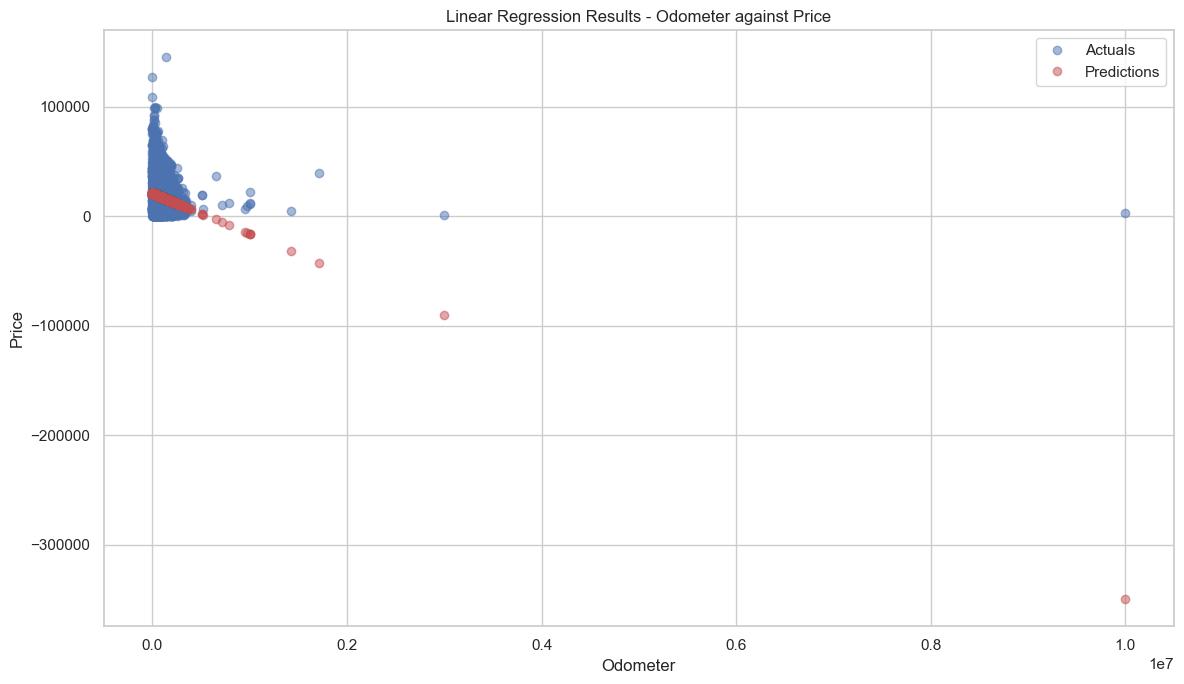

In [379]:
# Visualization of how the first_model did 
plt.figure(figsize=(12, 7))
plt.plot(X1_test.odometer, y1_test, 'ob', label='Actuals', alpha=0.5)
plt.plot(X1_test.odometer, test1_predictions, 'or', label='Predictions', alpha=0.5)
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.title('Linear Regression Results - Odometer against Price')
plt.legend()
plt.show()

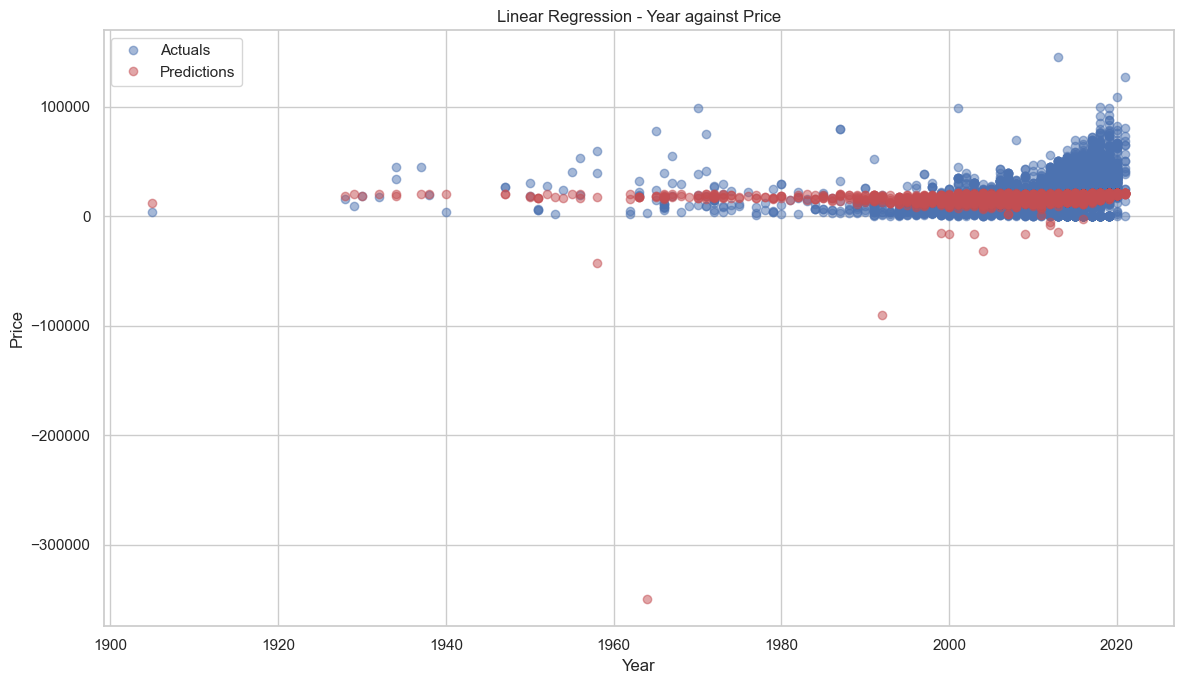

In [380]:
# Visualization of how well the model did by plotting the actual and predicted values
plt.figure(figsize=(12, 7))
plt.plot(X1_test.year, y1_test, 'ob', label='Actuals', alpha=0.5)
plt.plot(X1_test.year, test1_predictions, 'or', label='Predictions', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Linear Regression - Year against Price')
plt.legend()
plt.show()

`The linear regression model results do not yield a reliable model for price prediction. We could explore other categorical variables such as condition, fuel type, size, etc., I suspect the outcome may be similar due to issues with the price data.`

`Let's instead evaluate using the mean and median values for Odometer and Price to see if we can update these values effectively.`

In [382]:
# Prediction using all input values as parameters

# Various examples of cars with mileage, year, and descriptions
vehicle_examples = [
    (100, 2022, "New car with 100 miles, excellent condition"),
    (25000, 2020, "Used car with 25,000 miles, good condition"),
    (50000, 2018, "Used car with 50,000 miles, fair condition"),
    (90000, 2015, "Old car with 90,000 miles, fair condition"),
    (150000, 2005, "Very old car with 150,000 miles, poor condition"),
    (10, 2023, "Brand new car with 10 miles, excellent condition"),
]

# Make predictions for each car example
for miles, year, description in vehicle_examples:
    prediction = first_model.predict([[miles, year]])
    print(f"{description}: Predicted Price = ${prediction[0]:,.2f}")


New car with 100 miles, excellent condition: Predicted Price = $21,112.15
Used car with 25,000 miles, good condition: Predicted Price = $20,170.06
Used car with 50,000 miles, fair condition: Predicted Price = $19,224.28
Old car with 90,000 miles, fair condition: Predicted Price = $17,713.11
Very old car with 150,000 miles, poor condition: Predicted Price = $15,388.91
Brand new car with 10 miles, excellent condition: Predicted Price = $21,125.92


In [383]:
# Initialize lists to store mean squared errors
train1_mses = []
test1_mses = []

# Evaluate polynomial models of degrees 1 through 7
for degree in range(1, 8):
    pipe = Pipeline([
        ('pfeat', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linreg', LinearRegression())
    ])
    pipe.fit(X1_train, y1_train)
    
    # Predictions
    train1_preds = pipe.predict(X1_train)
    test1_preds = pipe.predict(X1_test)
    
    # Calculate and store mean squared errors
    train1_mses.append(mean_squared_error(y1_train, train1_preds))
    test1_mses.append(mean_squared_error(y1_test, test1_preds))

# Determine the best model complexity
best_model_complexity1 = test1_mses.index(min(test1_mses)) + 1

# Print results
print("Training MSEs:", np.round(train1_mses, 2))
print("Testing MSEs:", np.round(test1_mses, 2))
print("Best Model Complexity (Degree):", best_model_complexity1)

Training MSEs: [1.51171769e+08 1.29280259e+08 1.38196852e+08 1.35527990e+08
 1.42654209e+08 1.69846673e+08 1.74526093e+08]
Testing MSEs: [1.54860845e+08 1.32683199e+08 8.38242532e+08 8.35735519e+11
 2.71602646e+12 2.93840437e+14 9.73157731e+13]
Best Model Complexity (Degree): 2


Best Model Complexity: 2, Minimal MSE: 132683199.33200964


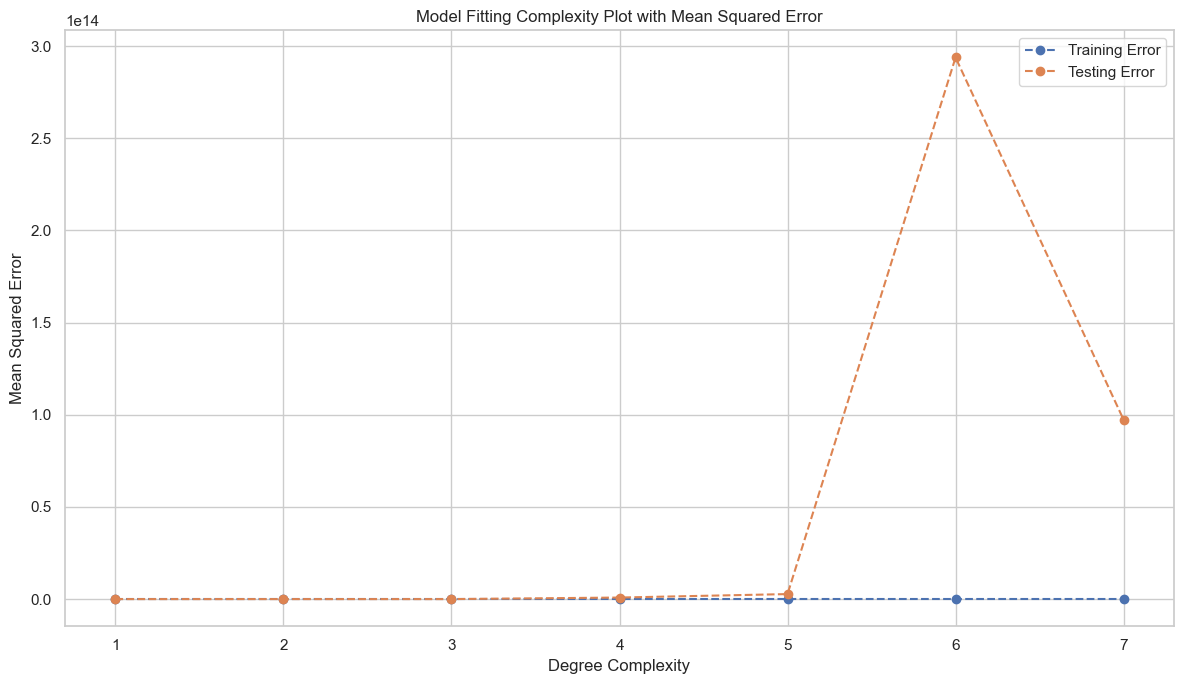

In [384]:
# Determine the best model complexity and minimal MSE
best_complexity = test1_mses.index(min(test1_mses)) + 1
minimal_mse = min(test1_mses)

# Print results
print(f'Best Model Complexity: {best_complexity}, Minimal MSE: {minimal_mse}')

# Visualization of model fitting results
plt.figure(figsize=(12, 7))
plt.title('Model Fitting Complexity Plot with Mean Squared Error')
plt.plot(range(1, 8), train1_mses, '--o', label='Training Error')
plt.plot(range(1, 8), test1_mses, '--o', label='Testing Error')
plt.xticks(range(1, 8))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

As you can see from the above plot the best model complexity and minimal MSE how training vs testing performed

Ridge Regression Test Score: 0.1082
Permutation Importance (Mean):
year        0.148678
odometer    0.072991
dtype: float64


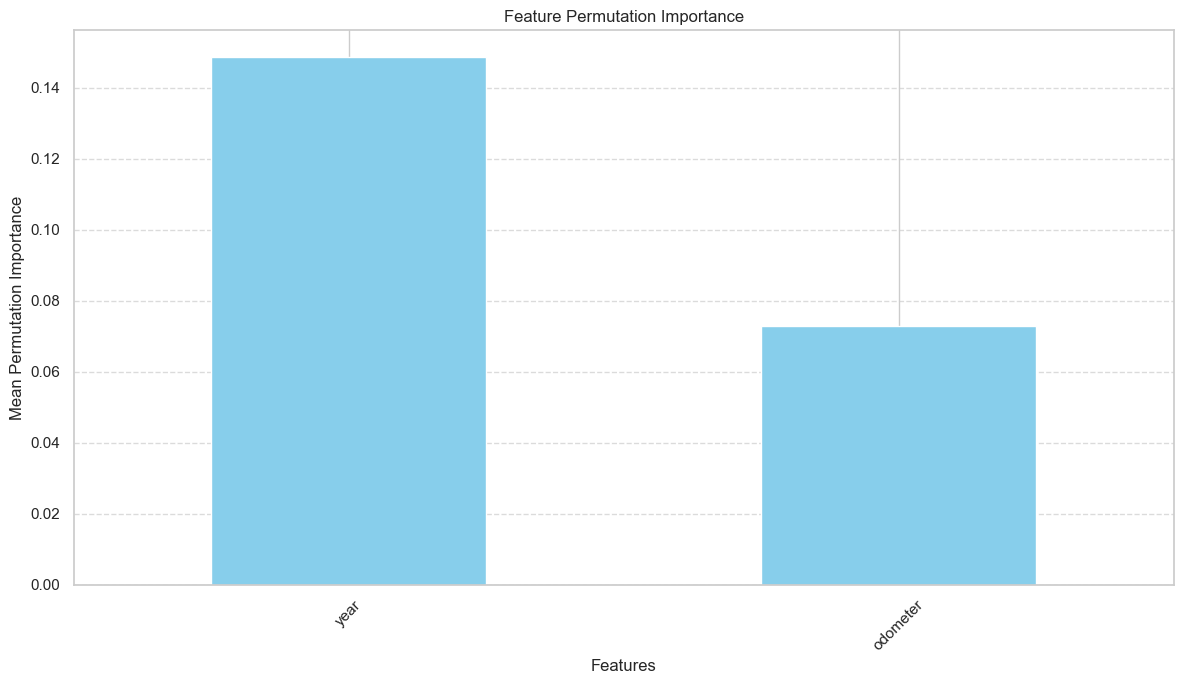

In [386]:
# Fit a Ridge regression model
modelR = Ridge(alpha=1e-2)
modelR.fit(X1_train, y1_train)

# Evaluate the model's performance on the test set
test1_score = modelR.score(X1_test, y1_test)
print(f"Ridge Regression Test Score: {test1_score:.4f}")

# Calculate permutation importance
r = permutation_importance(modelR, X1_test, y1_test, n_repeats=30, random_state=0)

# Create a DataFrame for the mean importances and sort them
perm_df = pd.Series(r.importances_mean, index=X1_test.columns).sort_values(ascending=False)

# Display the permutation importance values
print("Permutation Importance (Mean):")
print(perm_df)

# Plotting the permutation importance as a bar chart
plt.figure(figsize=(12, 7))
perm_df.plot(kind='bar', color='skyblue')
plt.title("Feature Permutation Importance")
plt.ylabel("Mean Permutation Importance")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Based on the bar plot, it appears that the year is more influential than the odometer reading. Additionally, all models were built using *LinearRegression(fit_intercept=False)*, which forces the y-intercept to 0, essentially setting the intercept at the origin (0, 0). Using *fit_intercept=False* helped generate predictions that reduced the number of negative price values.

In [388]:
# Let start the clean up by copying the data
new_vehicle_data_df = data_model.copy()
new_vehicle_data_df

price    year  odometer  condition_excellent  condition_fair  \
215      4000  2002.0  155000.0                 True           False   
219      2500  1995.0  110661.0                False            True   
268      9000  2008.0   56700.0                 True           False   
337      8950  2011.0  164000.0                 True           False   
338      4000  1972.0   88100.0                False            True   
...       ...     ...       ...                  ...             ...   
426785  23495  2015.0  146795.0                False           False   
426788  12995  2016.0   61127.0                False           False   
426792  32999  2014.0  154642.0                 True           False   
426793  15999  2018.0   36465.0                 True           False   
426833   6800  1997.0   69550.0                False           False   

        condition_good  condition_like new  condition_new  condition_salvage  \
215              False               False          False              False   
219              False               False          False              False   
268              False               False          False              False   
337              False               False          False              False   
338              False               False          False              False   
...                ...                 ...            ...                ...   
426785           False                True          False              False   
426788           False                True          False              False   
426792           False               False          False              False   
426793           False               False          False              False   
426833            True               False          False              False   

        fuel_diesel  ...  fuel_gas  fuel_hybrid  fuel_other  size_compact  \
215           False  ...      True        False       False          True   
219           False  ...      True        False       False         False   
268           False  ...      True        False       False          True   
337           False  ...      True        False       False         False   
338           False  ...      True        False       False         False   
...             ...  ...       ...          ...         ...           ...   
426785        False  ...      True        False       False         False   
426788        False  ...      True        False       False          True   
426792         True  ...     False        False       False         False   
426793        False  ...      True        False       False         False   
426833        False  ...      True        False       False          True   

        size_full-size  size_mid-size  size_sub-compact  drive_4wd  drive_fwd  \
215              False          False             False      False       True   
219              False           True             False      False      False   
268              False          False             False      False      False   
337               True          False             False      False       True   
338               True          False             False      False      False   
...                ...            ...               ...        ...        ...   
426785            True          False             False       True      False   
426788           False          False             False      False       True   
426792            True          False             False       True      False   
426793           False           True             False      False       True   
426833           False          False             False      False      False   

        drive_rwd  
215         False  
219          True  
268          True  
337         False  
338          True  
...           ...  
426785      False  
426788      False  
426792      False  
426793      False  
426833       True  

[32432 rows x 21 columns]

In [389]:
# mean Odometer
print('The mean of "Odometer" is %.2f' %(new_vehicle_data_df["odometer"].mean(skipna=True)))
# median Odometer
print('The median of "Odometer" is %.2f' %(new_vehicle_data_df["odometer"].median(skipna=True)))

# mean Price
print('The mean of "Price" is %.2f' %(new_vehicle_data_df["price"].mean(skipna=True)))
# median Price
print('The median of "Price" is %.2f' %(new_vehicle_data_df["price"].median(skipna=True)))

The mean of "Odometer" is 109198.25
The median of "Odometer" is 105722.00
The mean of "Price" is 16982.50
The median of "Price" is 13000.00


In [390]:
# Check if there is still bad data in the data set, i.e., unrealistic values in like less than 5000
check = new_vehicle_data_df.lt(5000).any()
check

price                  True
year                   True
odometer               True
condition_excellent    True
condition_fair         True
condition_good         True
condition_like new     True
condition_new          True
condition_salvage      True
fuel_diesel            True
fuel_electric          True
fuel_gas               True
fuel_hybrid            True
fuel_other             True
size_compact           True
size_full-size         True
size_mid-size          True
size_sub-compact       True
drive_4wd              True
drive_fwd              True
drive_rwd              True
dtype: bool

As observed, there are price and odometer values below 5000 for used cars. While the odometer readings may be reasonable, given that some cars are from 2020, we assume that any records with a price or odometer value of 5000 are invalid. Therefore, we will remove these records from the dataset.

In [392]:
# Remove records with Odometer and Price less than 5000
new_vehicle_data_df1 = new_vehicle_data_df.query("odometer > 5000 and price > 5000")
new_vehicle_data_df1

price    year  odometer  condition_excellent  condition_fair  \
268      9000  2008.0   56700.0                 True           False   
337      8950  2011.0  164000.0                 True           False   
346     98900  2001.0   20187.0                False           False   
355      9400  2008.0  129473.0                False           False   
364      7300  2007.0  181000.0                False           False   
...       ...     ...       ...                  ...             ...   
426785  23495  2015.0  146795.0                False           False   
426788  12995  2016.0   61127.0                False           False   
426792  32999  2014.0  154642.0                 True           False   
426793  15999  2018.0   36465.0                 True           False   
426833   6800  1997.0   69550.0                False           False   

        condition_good  condition_like new  condition_new  condition_salvage  \
268              False               False          False              False   
337              False               False          False              False   
346               True               False          False              False   
355               True               False          False              False   
364               True               False          False              False   
...                ...                 ...            ...                ...   
426785           False                True          False              False   
426788           False                True          False              False   
426792           False               False          False              False   
426793           False               False          False              False   
426833            True               False          False              False   

        fuel_diesel  ...  fuel_gas  fuel_hybrid  fuel_other  size_compact  \
268           False  ...      True        False       False          True   
337           False  ...      True        False       False         False   
346           False  ...      True        False       False         False   
355           False  ...      True        False       False         False   
364           False  ...      True        False       False         False   
...             ...  ...       ...          ...         ...           ...   
426785        False  ...      True        False       False         False   
426788        False  ...      True        False       False          True   
426792         True  ...     False        False       False         False   
426793        False  ...      True        False       False         False   
426833        False  ...      True        False       False          True   

        size_full-size  size_mid-size  size_sub-compact  drive_4wd  drive_fwd  \
268              False          False             False      False      False   
337               True          False             False      False       True   
346              False           True             False      False      False   
355               True          False             False      False      False   
364              False           True             False      False       True   
...                ...            ...               ...        ...        ...   
426785            True          False             False       True      False   
426788           False          False             False      False       True   
426792            True          False             False       True      False   
426793           False           True             False      False       True   
426833           False          False             False      False      False   

        drive_rwd  
268          True  
337         False  
346          True  
355          True  
364         False  
...           ...  
426785      False  
426788      False  
426792      False  
426793      False  
426833       True  

[27816 rows x 21 columns]

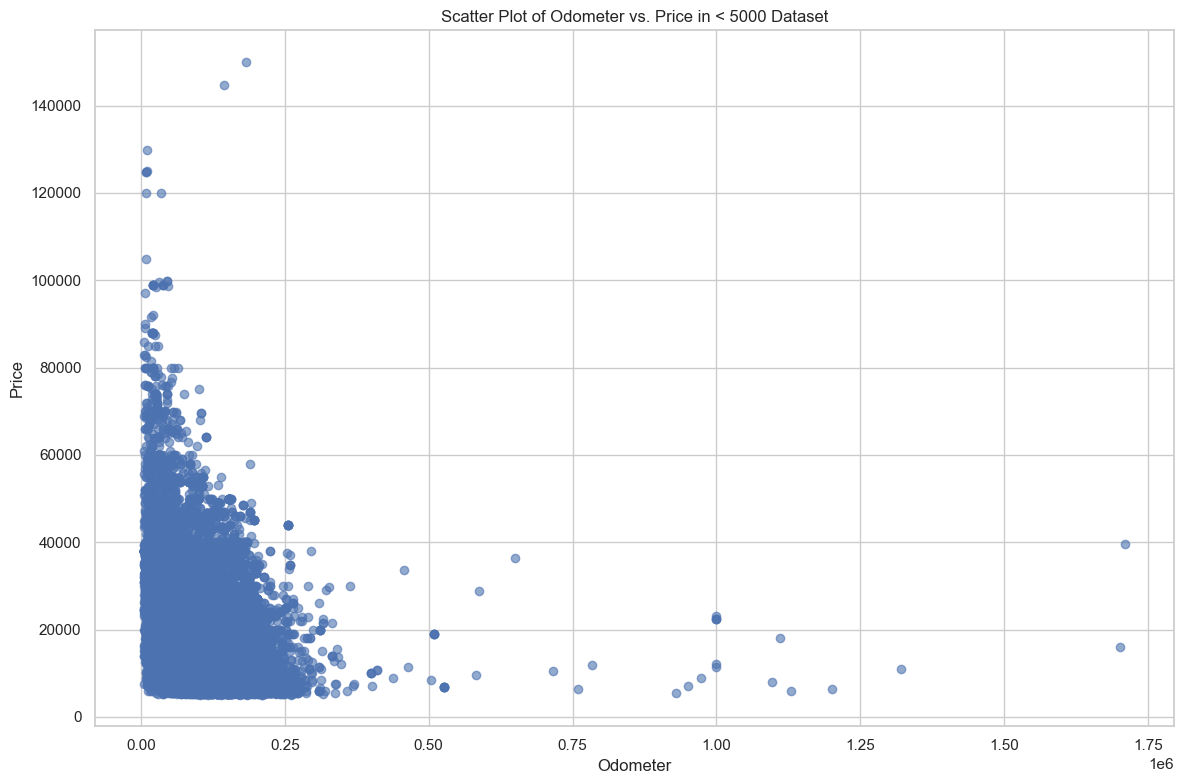

In [393]:
# Create a scatter plot of odometer vs. price
plt.figure(figsize=(12, 8))
plt.scatter(new_vehicle_data_df1['odometer'], new_vehicle_data_df1['price'], alpha=0.6)
plt.title('Scatter Plot of Odometer vs. Price in < 5000 Dataset')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.grid(True)  
plt.show()

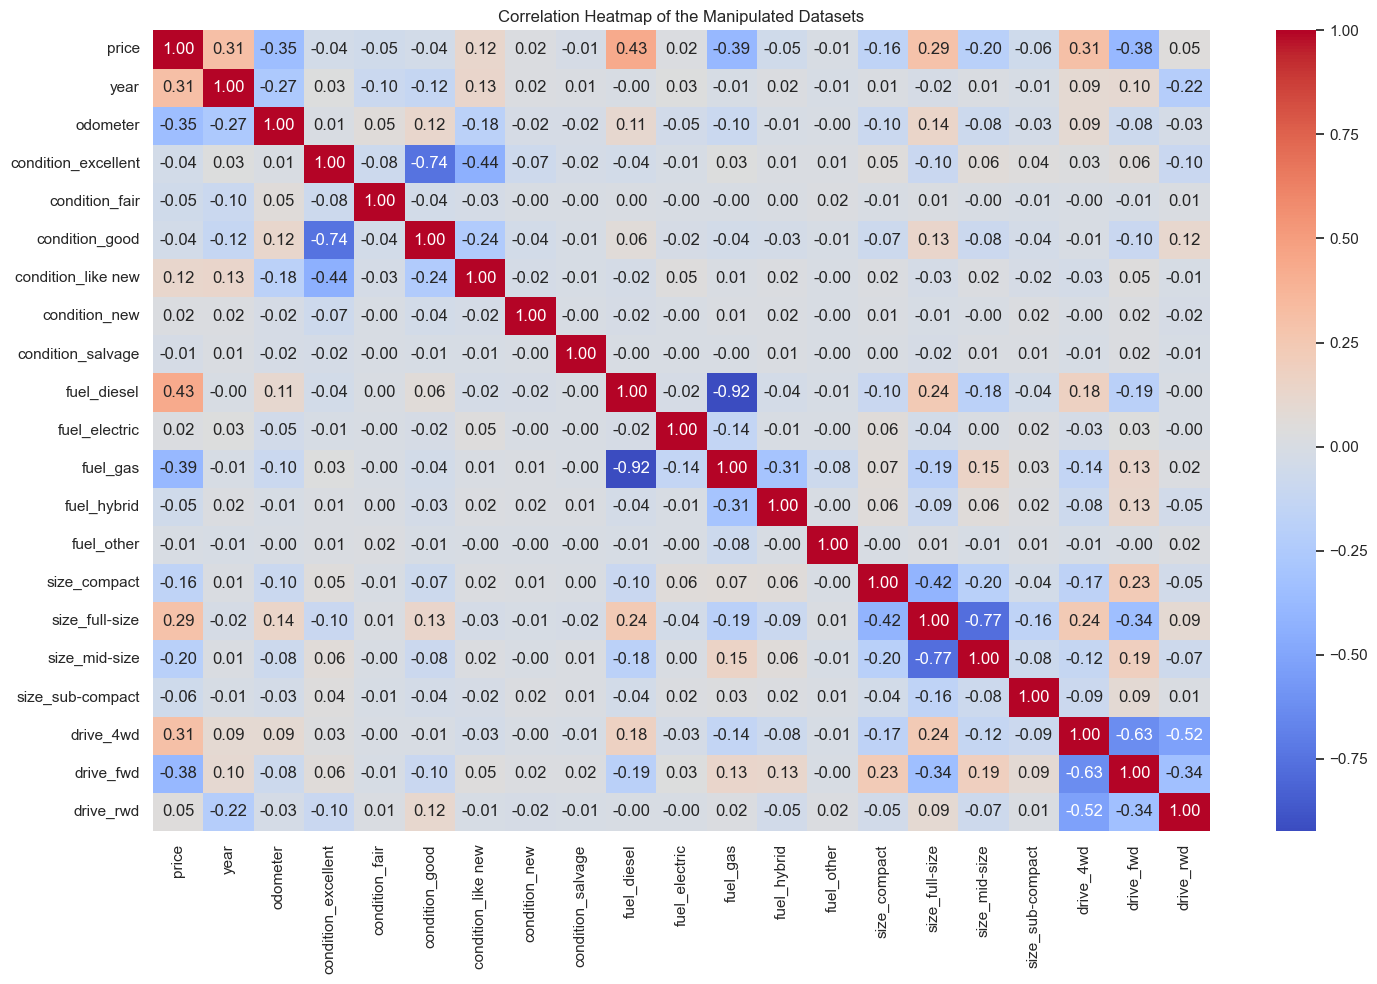

In [394]:
# Set up the figure
plt.figure(figsize=(15, 10))
plt.rcParams["figure.autolayout"] = True

# Create the seaborn heatmap
sns.heatmap(new_vehicle_data_df1.corr(), annot=True, cmap='coolwarm', fmt='.2f')

# Adding Title to the Plot
plt.title("Correlation Heatmap of the Manipulated Datasets")
plt.show()

``Second Model`` will be created using odometer and year in the dataset with "odometer > 5000 and price > 5000"

In [396]:
# Prepare data
X2 = new_vehicle_data_df1[['odometer', 'year']]
y2 = new_vehicle_data_df1['price']

# Split the data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=0)

# Fit the model
second_model = LinearRegression(fit_intercept=False)
second_model.fit(X2_train, y2_train)

# Print coefficients and intercept
print("Coefficient of the second model: ", second_model.coef_)
print("Intercept of the second model: ", second_model.intercept_)

# Get coefficients for each feature
coefficients = [(col, coef) for col, coef in zip(X2_train.columns, second_model.coef_)]
print("Feature coefficients: ", coefficients)

# Predictions on training set
train2_predictions = second_model.predict(X2_train)

# Compute and print accuracy and RMSE for training set
train2_score = second_model.score(X2_train, y2_train)
print("Training Accuracy: ", round(train2_score * 100, 2))
print("Training RMSE:     ", round(np.sqrt(mean_squared_error(y2_train, train2_predictions)), 2))

# Predictions on test set
test2_predictions = second_model.predict(X2_test)

# Compute and print accuracy and RMSE for test set
test2_score = second_model.score(X2_test, y2_test)
print("Test Accuracy: ", round(test2_score * 100, 2))
print("Test RMSE:     ", round(np.sqrt(mean_squared_error(y2_test, test2_predictions)), 2))

Coefficient of the second model:  [-0.07321818 13.17246703]
Intercept of the second model:  0.0
Feature coefficients:  [('odometer', -0.07321818401652598), ('year', 13.172467028829177)]
Training Accuracy:  12.45
Training RMSE:      11667.56
Test Accuracy:  12.54
Test RMSE:      11930.52


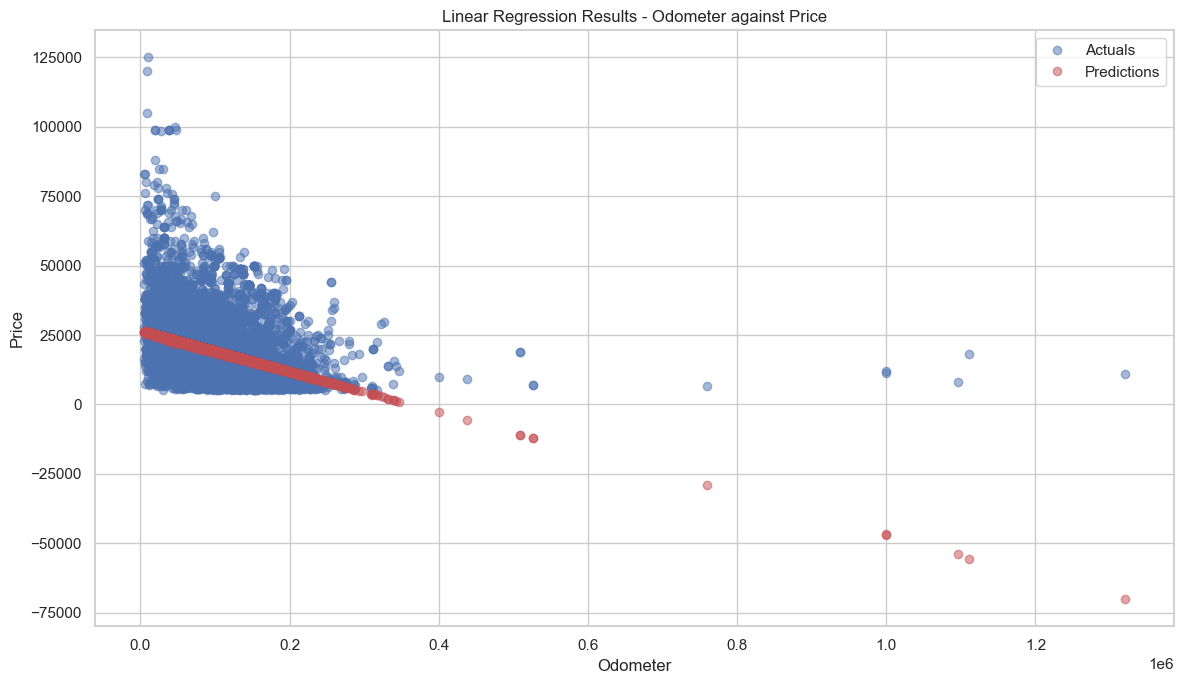

In [397]:
# Visualization of how the first_model did 
plt.figure(figsize=(12, 7))
plt.plot(X2_test.odometer, y2_test, 'ob', label='Actuals', alpha=0.5)
plt.plot(X2_test.odometer, test2_predictions, 'or', label='Predictions', alpha=0.5)
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.title('Linear Regression Results - Odometer against Price')
plt.legend()
plt.show()

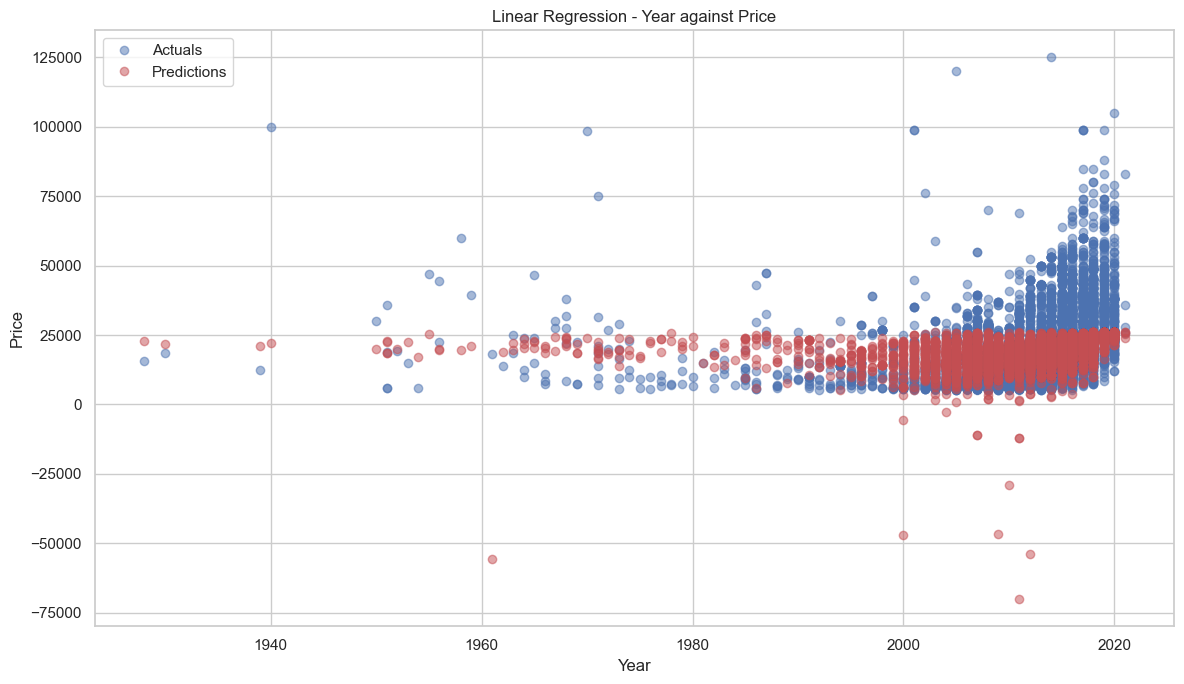

In [398]:
# Visualization of how well the model did by plotting the actual and predicted values
plt.figure(figsize=(12, 7))
plt.plot(X2_test.year, y2_test, 'ob', label='Actuals', alpha=0.5)
plt.plot(X2_test.year, test2_predictions, 'or', label='Predictions', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Linear Regression - Year against Price')
plt.legend()
plt.show()

In [399]:
# Prediction using all input values as parameters

# Various examples of cars with mileage, year, and descriptions
vehicle_examples2 = [
    (100, 2022, "New car with 100 miles, excellent condition"),
    (25000, 2020, "Used car with 25,000 miles, good condition"),
    (50000, 2018, "Used car with 50,000 miles, fair condition"),
    (90000, 2015, "Old car with 90,000 miles, fair condition"),
    (150000, 2005, "Very old car with 150,000 miles, poor condition"),
    (10, 2023, "Brand new car with 10 miles, excellent condition"),
]

# Make predictions for each car example
for miles, year, description in vehicle_examples2:
    prediction2 = second_model.predict([[miles, year]])
    print(f"{description}: Predicted Price = ${prediction2[0]:,.2f}")


New car with 100 miles, excellent condition: Predicted Price = $26,627.41
Used car with 25,000 miles, good condition: Predicted Price = $24,777.93
Used car with 50,000 miles, fair condition: Predicted Price = $22,921.13
Old car with 90,000 miles, fair condition: Predicted Price = $19,952.88
Very old car with 150,000 miles, poor condition: Predicted Price = $15,428.07
Brand new car with 10 miles, excellent condition: Predicted Price = $26,647.17


In [400]:
# Initialize lists to store mean squared errors
train2_mses = []
test2_mses = []

# Evaluate polynomial models of degrees 1 through 7
for degree in range(1, 8):
    pipe2 = Pipeline([
        ('pfeat', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linreg', LinearRegression())
    ])
    pipe2.fit(X2_train, y2_train)
    
    # Predictions
    train2_preds = pipe2.predict(X2_train)
    test2_preds = pipe2.predict(X2_test)
    
    # Calculate and store mean squared errors
    train2_mses.append(mean_squared_error(y2_train, train2_preds))
    test2_mses.append(mean_squared_error(y2_test, test2_preds))

# Determine the best model complexity
best_model_complexity2 = test2_mses.index(min(test2_mses)) + 1

# Print results
print("Training MSEs:", np.round(train2_mses, 2))
print("Testing MSEs:", np.round(test2_mses, 2))
print("Best Model Complexity (Degree):", best_model_complexity2)

Training MSEs: [1.28648276e+08 1.14358819e+08 1.12537038e+08 1.17756719e+08
 1.16665864e+08 1.25311878e+08 1.39753130e+08]
Testing MSEs: [1.34926745e+08 1.20747774e+08 1.19996314e+08 1.25326684e+08
 1.32031264e+08 1.34303921e+08 1.80122217e+08]
Best Model Complexity (Degree): 3


Best Model Complexity: 3, Minimal MSE: 119996314.21369706


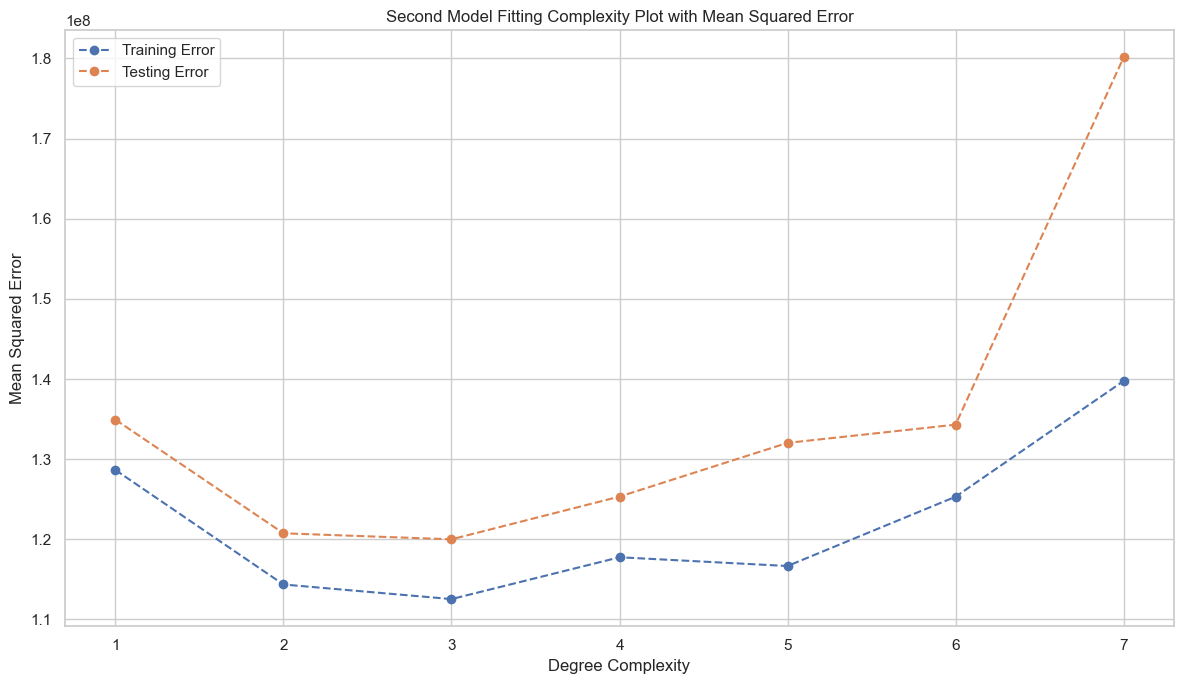

In [401]:
# Determine the best model complexity and minimal MSE
best_complexity2 = test2_mses.index(min(test2_mses)) + 1
minimal_mse2 = min(test2_mses)

# Print results
print(f'Best Model Complexity: {best_complexity2}, Minimal MSE: {minimal_mse2}')

# Visualization of model fitting results
plt.figure(figsize=(12, 7))
plt.title('Second Model Fitting Complexity Plot with Mean Squared Error')
plt.plot(range(1, 8), train2_mses, '--o', label='Training Error')
plt.plot(range(1, 8), test2_mses, '--o', label='Testing Error')
plt.xticks(range(1, 8))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Ridge Regression Test Score: 0.1710
Permutation Importance (Mean):
odometer    0.159575
year        0.110169
dtype: float64


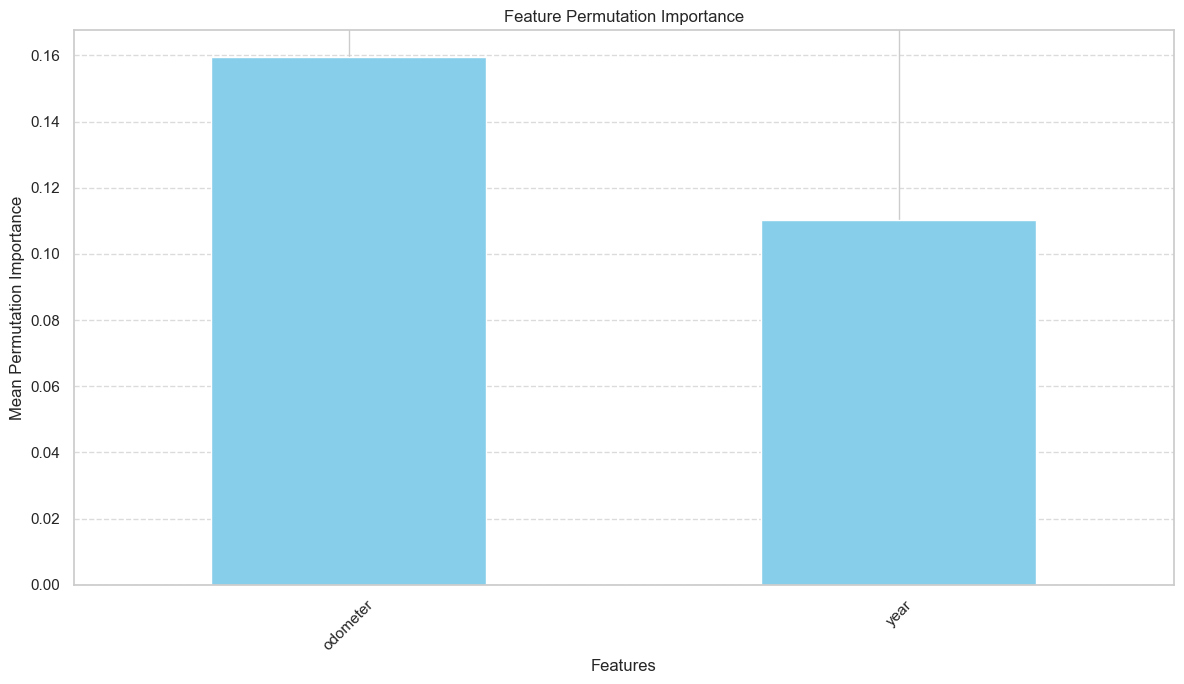

In [402]:
# Fit a Ridge regression model
modelR2 = Ridge(alpha=1e-2)
modelR2.fit(X2_train, y2_train)

# Evaluate the model's performance on the test set
test2_score = modelR2.score(X2_test, y2_test)
print(f"Ridge Regression Test Score: {test2_score:.4f}")

# Calculate permutation importance
r2 = permutation_importance(modelR2, X2_test, y2_test, n_repeats=30, random_state=0)

# Create a DataFrame for the mean importances and sort them
perm_df2 = pd.Series(r2.importances_mean, index=X2_test.columns).sort_values(ascending=False)

# Display the permutation importance values
print("Permutation Importance (Mean):")
print(perm_df2)

# Plotting the permutation importance as a bar chart
plt.figure(figsize=(12, 7))
perm_df2.plot(kind='bar', color='skyblue')
plt.title("Feature Permutation Importance")
plt.ylabel("Mean Permutation Importance")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Above plot of Second Model of the permutation importance result, odometer is more important than year

``Third_Model`` will be created using `year` in the dataset with `odometer > 5000 and price > 5000`

Lets see the regression models using other features like year and odometer to see if there are any
noticable correlation


Training Accuracy: 0.3
Training RMSE: 12450.35
Test Accuracy: 0.26
Test RMSE: 12741.11


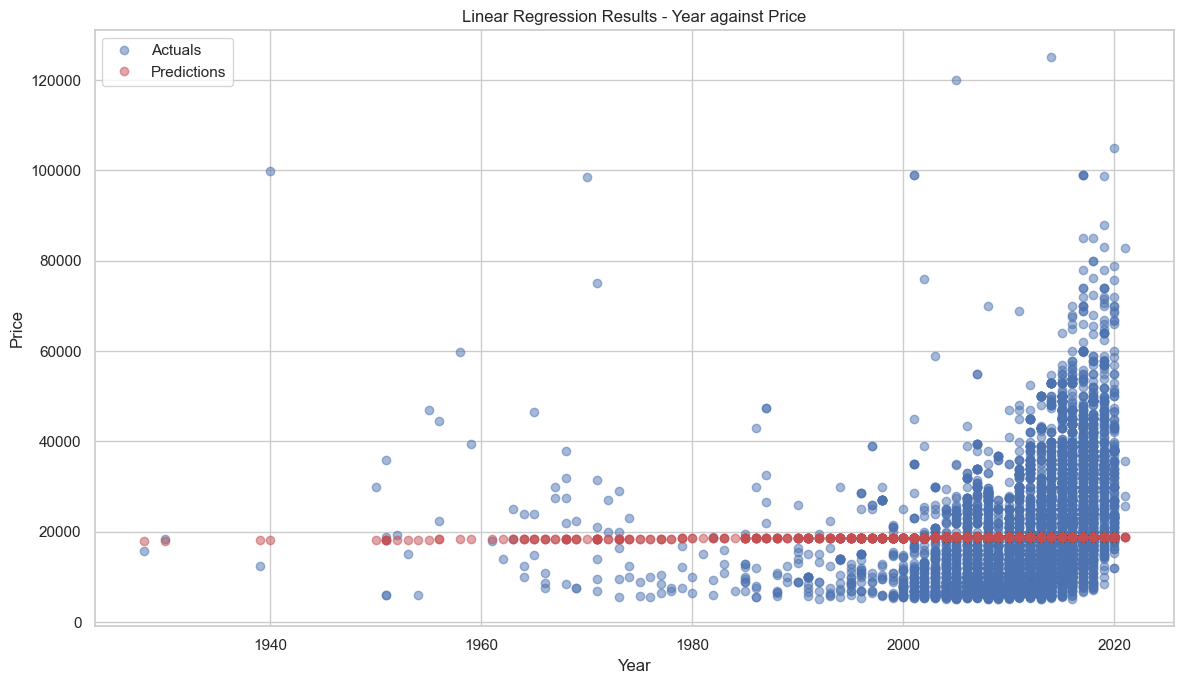

In [405]:
# Define the function (uncomment this line if needed)
# def run_regression(data, feature, target):
X3 = new_vehicle_data_df1[['year']]
y3 = new_vehicle_data_df1.price

# Split the data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=0)

# Fit the model
third_model = LinearRegression(fit_intercept=False).fit(X3_train, y3_train)

# Print metrics for training and test sets
for dataset, label in zip([(X3_train, y3_train), (X3_test, y3_test)], ['Training', 'Test']):
    predictions3 = third_model.predict(dataset[0])
    print(f"{label} Accuracy: {round(third_model.score(dataset[0], dataset[1]) * 100, 2)}")
    print(f"{label} RMSE: {round(np.sqrt(mean_squared_error(dataset[1], predictions3)), 2)}")

# Visualization
plt.figure(figsize=(12, 7))
plt.plot(X3_test['year'], y3_test, 'ob', label='Actuals', alpha=0.5)
plt.plot(X3_test['year'], third_model.predict(X3_test), 'or', label='Predictions', alpha=0.5)  # Corrected to use 'year' for predictions
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Linear Regression Results - Year against Price')
plt.legend()
plt.show()


In [406]:
# Prediction using all input values as parameters

# Various examples of cars with mileage, year, and descriptions
vehicle_examples3 = [
    (2022, "Year 2022, excellent condition"),
    (2020, "Year 2020, good condition"),
    (2018, "Year 2018, fair condition"),
    (2015, "Year 2015, fair condition"),
    (2005, "Year 2005, poor condition"),
    (2023, "Year 2023, excellent condition"),
]

# Make predictions for each car example
for year, description in vehicle_examples3:
    prediction3 = third_model.predict([[year]])
    print(f"{description}: Predicted Price = ${prediction3[0]:,.2f}")



Year 2022, excellent condition: Predicted Price = $18,933.35
Year 2020, good condition: Predicted Price = $18,914.62
Year 2018, fair condition: Predicted Price = $18,895.89
Year 2015, fair condition: Predicted Price = $18,867.80
Year 2005, poor condition: Predicted Price = $18,774.16
Year 2023, excellent condition: Predicted Price = $18,942.71


``Fourth_Model`` will be created using `odometer` in the dataset with `odometer > 5000 and price > 5000`

Coefficient of the model:  [0.11838402]
Intercept of the model:  0.0
Accuracy:  -97.45
RMSE:      17521.26
Test Accuracy:  -96.91
Test RMSE:      17901.61
Predicted Prices based on Odometer Readings:
Car with Odometer of 10,000: $1,183.84
Car with Odometer of 50,000: $5,919.20
Car with Odometer of 90,000: $10,654.56
Car with Odometer of 100,000: $11,838.40


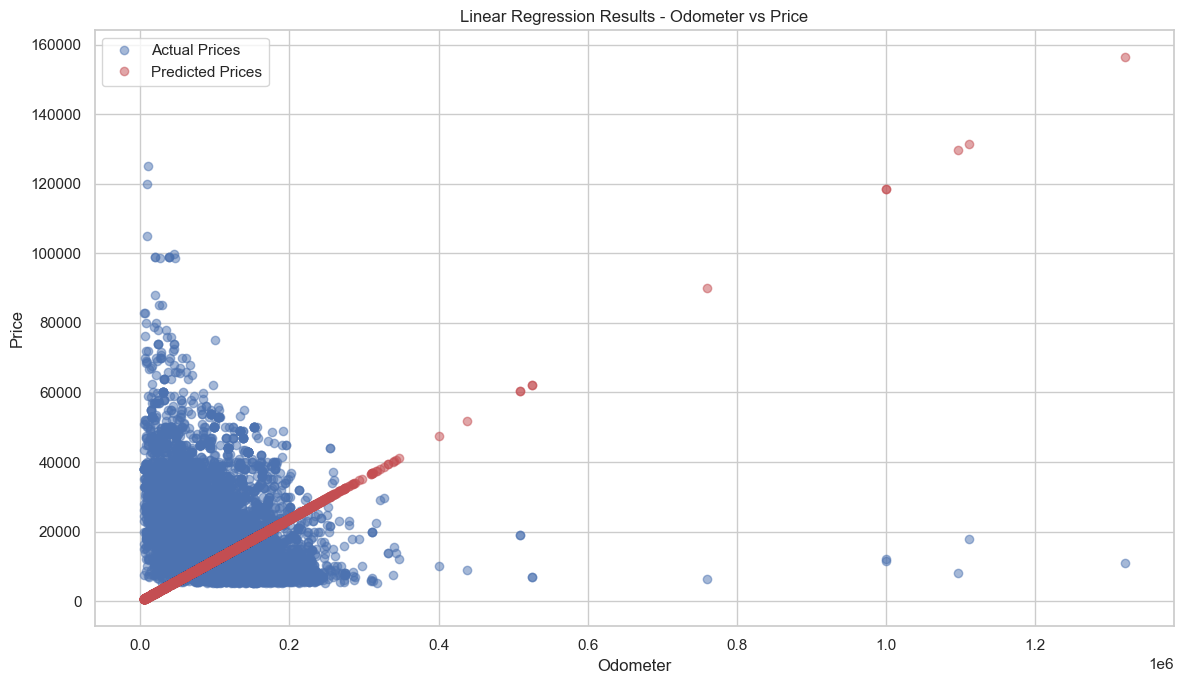

In [408]:
# Run Regression using odometer for Price Prediction
X4 = new_vehicle_data_df1[['odometer']]  # Keeping the original variable name
y4 = new_vehicle_data_df1['price']  # Keeping the original variable name

# Split the data into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=0)

# Initialize and fit the Linear Regression model
fourth_model = LinearRegression(fit_intercept=False)
fourth_model.fit(X4_train, y4_train)

# Print model coefficients and intercept
print("Coefficient of the model: ", fourth_model.coef_)
print("Intercept of the model: ", fourth_model.intercept_)

# Compute predictions for the training set
train4_predictions = fourth_model.predict(X4_train)

# Compute Accuracy and RMSE for the training model
score4 = fourth_model.score(X4_train, y4_train)
print("Accuracy: ", round(score4 * 100, 2))
print("RMSE:     ", round(np.sqrt(mean_squared_error(y4_train, train4_predictions)), 2))

# Using the model to make predictions of Price on the test set
test4_predictions = fourth_model.predict(X4_test)

# Compute Accuracy and RMSE for the test model
score4_test = fourth_model.score(X4_test, y4_test)  # Renamed to avoid confusion
print("Test Accuracy: ", round(score4_test * 100, 2))
print("Test RMSE:     ", round(np.sqrt(mean_squared_error(y4_test, test4_predictions)), 2))

# Visualization of how well the model did by plotting the actual and predicted values
fig, plt = plt.subplots(1, 1, figsize=(12, 7))
plt.plot(X4_test['odometer'], y4_test, 'ob', label='Actual Prices', alpha=0.5)  # Changed label for clarity
plt.plot(X4_test['odometer'], test4_predictions, 'or', label='Predicted Prices', alpha=0.5)  # Changed label for clarity
plt.set(xlabel='Odometer', ylabel='Price')
plt.legend()
plt.set_title('Linear Regression Results - Odometer vs Price')

def predict_price(odometer_reading):
    """Predict the price of a vehicle based on its odometer reading."""
    predicted_price = fourth_model.predict([[odometer_reading]])[0]  # Get the predicted price
    return predicted_price

# List of odometer readings to predict prices for
odometer_readings = [10000, 50000, 90000, 100000]

# Print predictions for each odometer reading
print("Predicted Prices based on Odometer Readings:")
for reading in odometer_readings:
    price = predict_price(reading)  
    print(f"Car with Odometer of {reading:,}: ${price:,.2f}")  # Format output for readability

`Fifth_Model` will be developed using all available features in the dataset, with the condition "odometer > 5000 and price > 5000." The goal is to assess the complexity of the model by comparing the use of OneHotEncoder versus `get_dummies` for converting categorical variables into dummy/indicator variables.

In [410]:
# Using OneHotEncoder and permutation importance to determine the main features that impact used car prices
data_v5 = data_v3.query("odometer > 5000 and price > 5000")
data_v5.head()

price    year  condition fuel  odometer drive       size
268   9000  2008.0  excellent  gas   56700.0   rwd    compact
337   8950  2011.0  excellent  gas  164000.0   fwd  full-size
346  98900  2001.0       good  gas   20187.0   rwd   mid-size
355   9400  2008.0       good  gas  129473.0   rwd  full-size
364   7300  2007.0       good  gas  181000.0   fwd   mid-size

In [411]:
data_v5.describe()

price          year      odometer
count   27816.000000  27816.000000  2.781600e+04
mean    18910.265926   2011.626043  1.047101e+05
std     12557.334892      6.615416  5.932711e+04
min      5100.000000   1927.000000  5.011000e+03
25%      9500.000000   2009.000000  6.691875e+04
50%     14995.000000   2013.000000  1.021260e+05
75%     24990.000000   2016.000000  1.369650e+05
max    150000.000000   2021.000000  1.710000e+06

In [412]:
X5 = data_v5.drop(columns='price')
y5 = data_v5['price']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.3, random_state = 0)

In [413]:
# Build models of degree 1 through 10 on X_train with y1_train as the target.
# Evaluate the mean_squared_error on the training data and the testing data 
# Determine the model complexity that minimizes the mean_squared_error on the test data
# Use OneHotEncoder as opposed to get_dummies to see if there are any differences in results.

feature_cols = ['odometer', 'year']
train_mses5 = []  # List to store training MSEs
test_mses5 = []   # List to store testing MSEs

best_mse5 = np.inf  # Initialize best MSE to infinity
best_pipe5 = None    # Placeholder for the best pipeline

# Loop through polynomial degrees from 1 to 9
for degree in range(1, 10):
    # Create a column transformer with OneHotEncoder and PolynomialFeatures
    col_transformer = make_column_transformer(
        (OneHotEncoder(), ['condition', 'fuel', 'drive', 'size']),
        (PolynomialFeatures(degree=degree, include_bias=False), feature_cols),
        remainder='passthrough'
    )
    
    # Create a pipeline with the column transformer and Linear Regression model
    pipe5 = Pipeline([
        ('col_transformer', col_transformer),
        ('model', LinearRegression())
    ])
    
    # Fit the pipeline to the training data
    pipe5.fit(X5_train, y5_train)

    # Make predictions on training and testing data
    train_preds5 = pipe5.predict(X5_train)
    test_preds5 = pipe5.predict(X5_test)

    # Calculate mean squared errors for training and testing data
    train_mse5 = mean_squared_error(train_preds5, y5_train)
    test_mse5 = mean_squared_error(test_preds5, y5_test)

    # Append the MSEs to their respective lists
    train_mses5.append(train_mse5)
    test_mses5.append(test_mse5)

    # Update the best MSE and corresponding pipeline if the current test MSE is lower
    if test_mse5 < best_mse5:
        best_mse5 = test_mse5
        best_pipe5 = pipe5

# Determine the model complexity that minimizes the test MSE
best_model_complexity5 = test_mses5.index(min(test_mses5)) + 1

# Print the results
print(f"Number of training MSEs: {len(train_mses5)}")
print(f"Training MSEs: {np.round(train_mses5, 2)}")
print(f"Number of testing MSEs: {len(test_mses5)}")
print(f"Testing MSEs: {np.round(test_mses5, 2)}")
print(f"Best model complexity: {best_model_complexity5}")

Number of training MSEs: 9
Training MSEs: [7.21384200e+07 5.83762339e+07 1.12537522e+08 1.17756721e+08
 1.16665871e+08 1.25346937e+08 1.39753130e+08 1.46887645e+08
 1.52249860e+08]
Number of testing MSEs: 9
Testing MSEs: [7.44246068e+07 6.12120362e+07 1.20019447e+08 1.25328776e+08
 1.32033822e+08 1.34442696e+08 1.80118245e+08 2.30635961e+08
 3.00864452e+08]
Best model complexity: 2


The Complexity that minimized Test Error was: 2
The minimal MSE was: 61212036.2097872


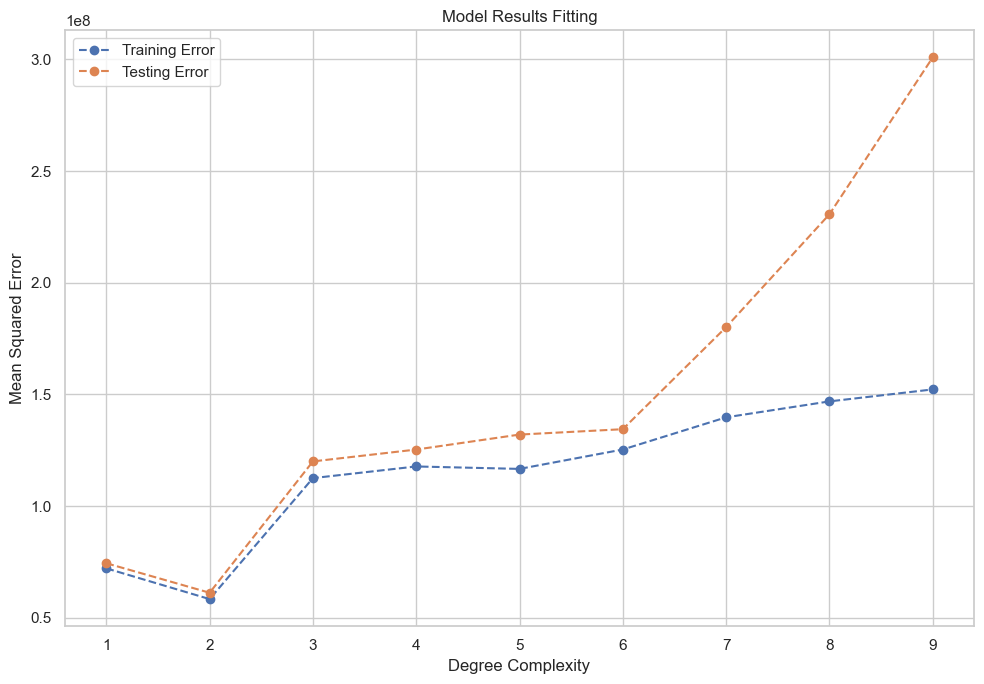

In [414]:
import matplotlib.pyplot as plt5  

# Visualize the results of model fitting
print(f'The Complexity that minimized Test Error was: {best_model_complexity5}')
print(f'The minimal MSE was: {min(test_mses5)}')

plt5.figure(figsize=(10, 7))
plt5.plot(range(1, 10), train_mses5, '--o', label='Training Error')
plt5.plot(range(1, 10), test_mses5, '--o', label='Testing Error')
plt5.xticks(range(1, 10), range(1, 10))
plt5.xlabel('Degree Complexity')
plt5.ylabel('Mean Squared Error')
plt5.title('Model Results Fitting')
plt5.legend()
plt5.show()  

`Observation:` The model complexity that minimized the test error value of 2 is similar to or identical to some of the previous model applications. This suggests that there is little to no difference between using `OneHotEncoder and get_dummies` for converting categorical variables into dummy/indicator variables.

``Sixth_Model`` application will be created using the features that have a better correlation with price in the dataset with "odometer > 5000 and price > 5000". Based on the above observations, we will use features odometer, year, fuel_diesel, drive_4wd and size_full-size

Coefficient of the model:  [-9.29055281e-02  1.03483761e+01  1.63674361e+04  5.73780578e+03
  5.37707748e+03]
Intercept of the model:  0.0
Accuracy:  45.26
RMSE:      9226.0
Accuracy:  46.88
RMSE:      9298.39
Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size:  [38785.03501702]
Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size:  [22417.5988814]
Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size:  [47456.98382732]
Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size:  [31089.5476917]


Text(0.5, 0, 'Vehicle Features')

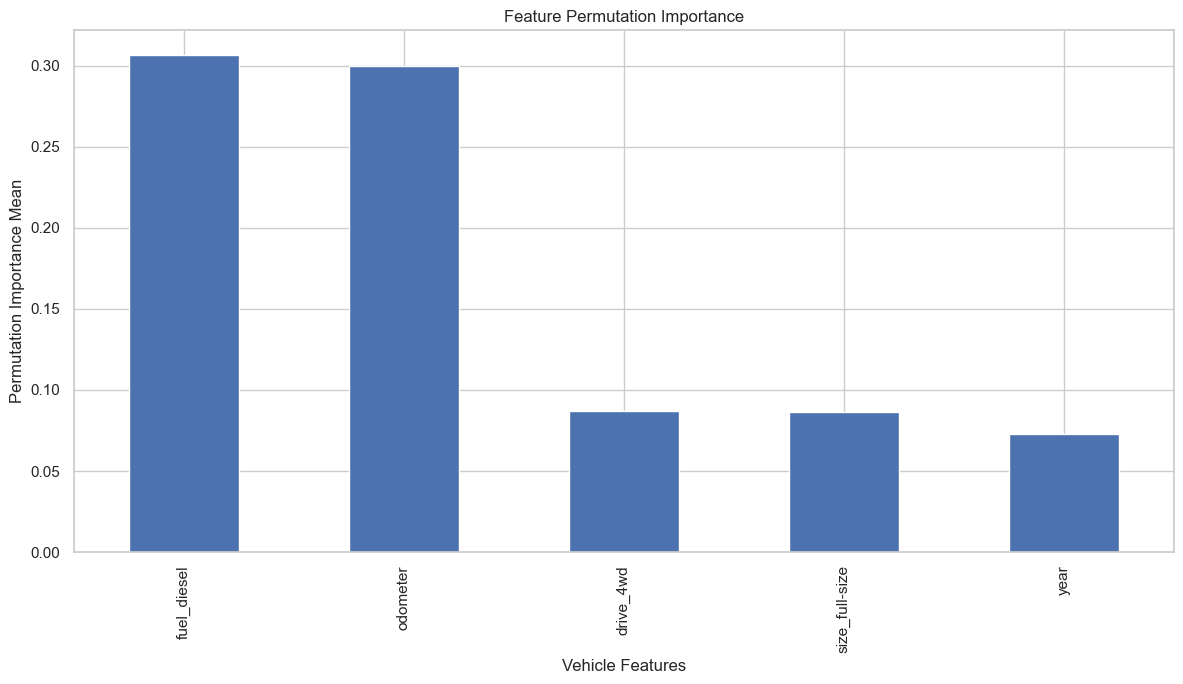

In [417]:
import matplotlib.pyplot as plt6  

# Create a model using Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction
# These features are the ones that have a positive correlation with car price
X6 = new_vehicle_data_df1[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y6 = new_vehicle_data_df1.price
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = 0.3, random_state = 0)
sixth_model=LinearRegression(fit_intercept=False)
sixth_model.fit(X6_train, y6_train)
print("Coefficient of the model: ",sixth_model.coef_)
print("Intercept of the model: ", sixth_model.intercept_)

#Let compute the predictions for the entire set of inputs
train6_predictions=sixth_model.predict(X6_train)

#Compute Accuracy and RMSE to training model
score6 = sixth_model.score(X6_train, y6_train)
print("Accuracy: ", round(score6*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y6_train,train6_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test6_predictions=sixth_model.predict(X6_test)

# Compute Accuracy and RMSE to test model
score6 = sixth_model.score(X6_test, y6_test)
print("Accuracy: ", round(score6*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y6_test,test6_predictions)), 2))

## Prediction using Odometer, Year, fuel_diesel, drive_4wd and size_full_size as input
print("Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: ", sixth_model.predict([[100000,1990,1,1,1]]))
print("Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: ", sixth_model.predict([[100000,1990,0,1,1]]))

print("Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: ", sixth_model.predict([[10000,2020,1,1,1]]))
print("Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: ", sixth_model.predict([[10000,2020,0,1,1]]))

#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to regression models

model6R = Ridge(alpha=1e-2).fit(X6_train, y6_train)
model6R.score(X6_test, y6_test)

#  permutation_importance function to probe which features are most predictive
r6 = permutation_importance(model6R, X6_test, y6_test, n_repeats=30, random_state=0)
# mean values for permutation_importance
perm_df6 = pd.Series(r6.importances_mean, index=X6_test.columns).sort_values(ascending=False)
perm_df6

# Bar chart plot of the mean values for permutation_importance
plt6.figure(figsize =(12, 7))
perm_df6.plot.bar(x=X6_test.columns, y=r6.importances_mean)

plt6.title("Feature Permutation Importance")
plt6.ylabel("Permutation Importance Mean")
plt6.xlabel("Vehicle Features")



`Observation:` Based on the used car Histogram plot earlier, we can safely assume that we can create the final model using the Used Cars from 1990 and the features Odometer, Year, fuel_diesel, drive_4wd and size_full-size

In [419]:
# Create a new dataframe with used cars from 1990 onwards
new_vehicle_data_1990_df = new_vehicle_data_df1.query("year > 1990")
new_vehicle_data_1990_df.head()

price    year  odometer  condition_excellent  condition_fair  \
268   9000  2008.0   56700.0                 True           False   
337   8950  2011.0  164000.0                 True           False   
346  98900  2001.0   20187.0                False           False   
355   9400  2008.0  129473.0                False           False   
364   7300  2007.0  181000.0                False           False   

     condition_good  condition_like new  condition_new  condition_salvage  \
268           False               False          False              False   
337           False               False          False              False   
346            True               False          False              False   
355            True               False          False              False   
364            True               False          False              False   

     fuel_diesel  ...  fuel_gas  fuel_hybrid  fuel_other  size_compact  \
268        False  ...      True        False       False          True   
337        False  ...      True        False       False         False   
346        False  ...      True        False       False         False   
355        False  ...      True        False       False         False   
364        False  ...      True        False       False         False   

     size_full-size  size_mid-size  size_sub-compact  drive_4wd  drive_fwd  \
268           False          False             False      False      False   
337            True          False             False      False       True   
346           False           True             False      False      False   
355            True          False             False      False      False   
364           False           True             False      False       True   

     drive_rwd  
268       True  
337      False  
346       True  
355       True  
364      False  

[5 rows x 21 columns]

In [420]:
new_vehicle_data_1990_df.shape

(27444, 21)

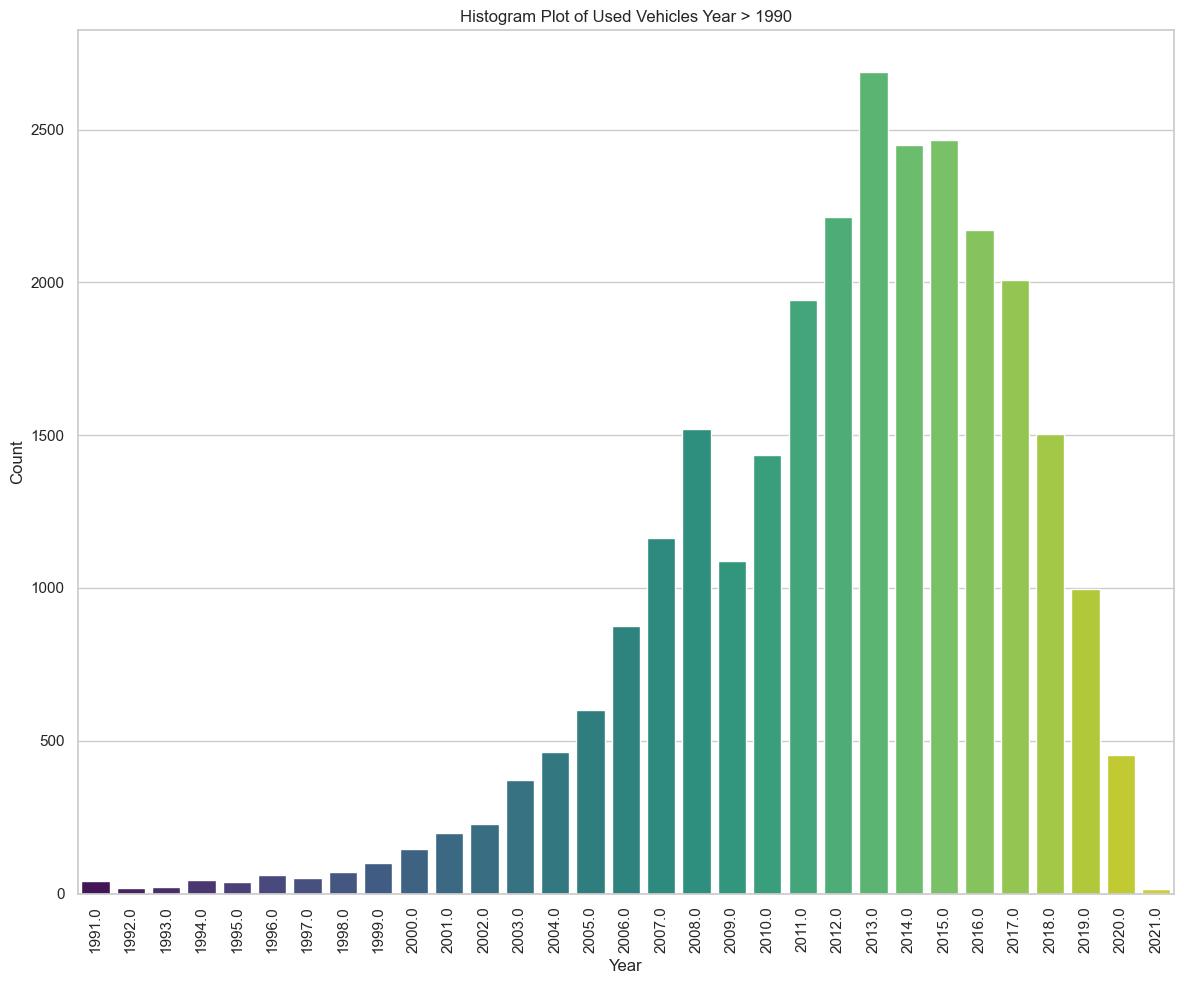

In [421]:
import matplotlib.pyplot as plt7

# Set up the figure and axis for the plot
fig, ax = plt7.subplots(figsize=(12, 10))

# Create a seaborn countplot for used car counts by year
sns.countplot(x='year', data=new_vehicle_data_1990_df, ax=ax, palette='viridis')

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Vehicles Year > 1990")

# Rotate x-axis tick labels for better readability
plt7.xticks(rotation=90)

# Setting the X and Y labels
ax.set_xlabel("Year")
ax.set_ylabel("Count")

# Show the plot
plt7.show()

The `Seventh_Model` will be developed using the features that show the strongest correlation with price in the dataset, filtered by the conditions "odometer > 5000", "price > 5000", and "year > 1990." The selected features are odometer, year, fuel_diesel, drive_4wd, and size_full-size.

In [423]:
# Create a model with features are the ones that have a positive correlation with 
# car price (Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction)

import matplotlib.pyplot as plt7

X7 = new_vehicle_data_1990_df[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y7 = new_vehicle_data_1990_df.price

# Split the data into training and testing sets
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size=0.3, random_state=0)

# Train the Linear Regression model
seventh_model = LinearRegression(fit_intercept=False)
seventh_model.fit(X7_train, y7_train)

# Print model coefficients and intercept
print("Coefficient of the model: ", seventh_model.coef_)
print("Intercept of the model: ", seventh_model.intercept_)

# Compute predictions for the training set
train7_predictions = seventh_model.predict(X7_train)

# Compute Accuracy and RMSE for the training model
score7 = seventh_model.score(X7_train, y7_train)
print("Training Accuracy: ", round(score7 * 100, 2))
print("Training RMSE:     ", round(np.sqrt(mean_squared_error(y7_train, train7_predictions)), 2))

# Using the model to make predictions on the test set
test7_predictions = seventh_model.predict(X7_test)

# Compute Accuracy and RMSE for the test model
score7 = seventh_model.score(X7_test, y7_test)
print("Test Accuracy: ", round(score7 * 100, 2))
print("Test RMSE:     ", round(np.sqrt(mean_squared_error(y7_test, test7_predictions)), 2))

# Prediction using Odometer, Year, fuel_diesel, drive_4wd and size_full-size as input
print("Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: ", 
      seventh_model.predict([[100000, 1990, 1, 1, 1]]))
print("Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: ", 
      seventh_model.predict([[100000, 1990, 0, 1, 1]]))
print("Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: ", 
      seventh_model.predict([[10000, 2020, 1, 1, 1]]))
print("Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: ", 
      seventh_model.predict([[10000, 2020, 0, 1, 1]]))


Coefficient of the model:  [-9.79393406e-02  1.05400863e+01  1.65377878e+04  5.88123006e+03
  5.50763744e+03]
Intercept of the model:  0.0
Training Accuracy:  47.52
Training RMSE:      9089.08
Test Accuracy:  48.26
Test RMSE:      8970.29
Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size:  [39107.49298477]
Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size:  [22569.70514759]
Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size:  [48238.23622874]
Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size:  [31700.44839156]


In [424]:
# Use the sklearn.inspection module's implementation of permutation importance
seventh_modelR = Ridge(alpha=1e-2).fit(X7_train, y7_train)
seventh_modelR.score(X7_test, y7_test)


0.5613509556616727

In [425]:
# Permutation importance to probe which features are most predictive
r7 = permutation_importance(seventh_modelR, X7_test, y7_test, n_repeats=30, random_state=0)

# Mean values for permutation importance
perm_df7 = pd.Series(r7.importances_mean, index=X7_test.columns).sort_values(ascending=False)
perm_df7

fuel_diesel       0.318646
year              0.208185
odometer          0.204708
drive_4wd         0.088106
size_full-size    0.085358
dtype: float64

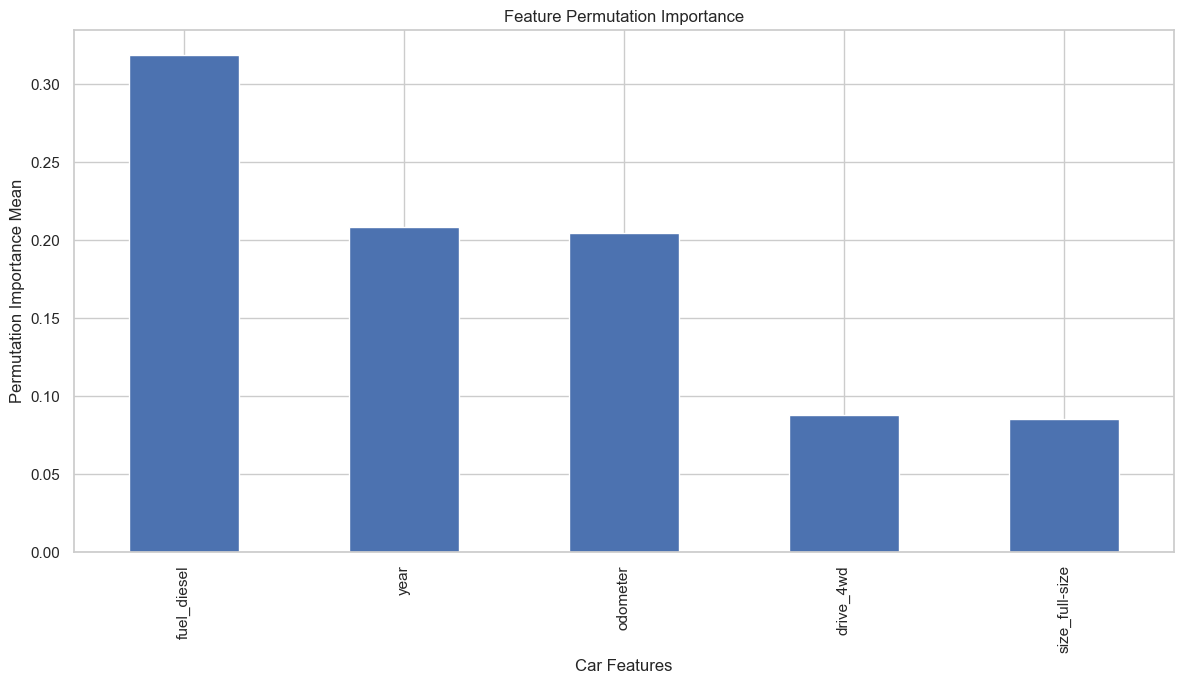

In [426]:
# Bar chart plot of the mean values for permutation importance
plt7.figure(figsize=(12, 7))
perm_df7.plot.bar()
plt7.title("Feature Permutation Importance")
plt7.ylabel("Permutation Importance Mean")
plt7.xlabel("Car Features")
plt7.show()

### `Eighth_model:` Let us now try Linear and Ridge regression models with cross validation

***********************

Linear Regression Model:
***********************

Training Accuracy: 47.52%
Training RMSE: 9089.08
Test Accuracy: 48.26%
Test RMSE: 8970.29
Model Coefficients: [-9.79393406e-02  1.05400863e+01  1.65377878e+04  5.88123006e+03
  5.50763744e+03]
Model Intercept: 0.0

******************************************

Linear Regression Model - Price Prediction:
******************************************

Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: $39107.49
Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: $22569.71
Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: $48238.24
Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: $31700.45


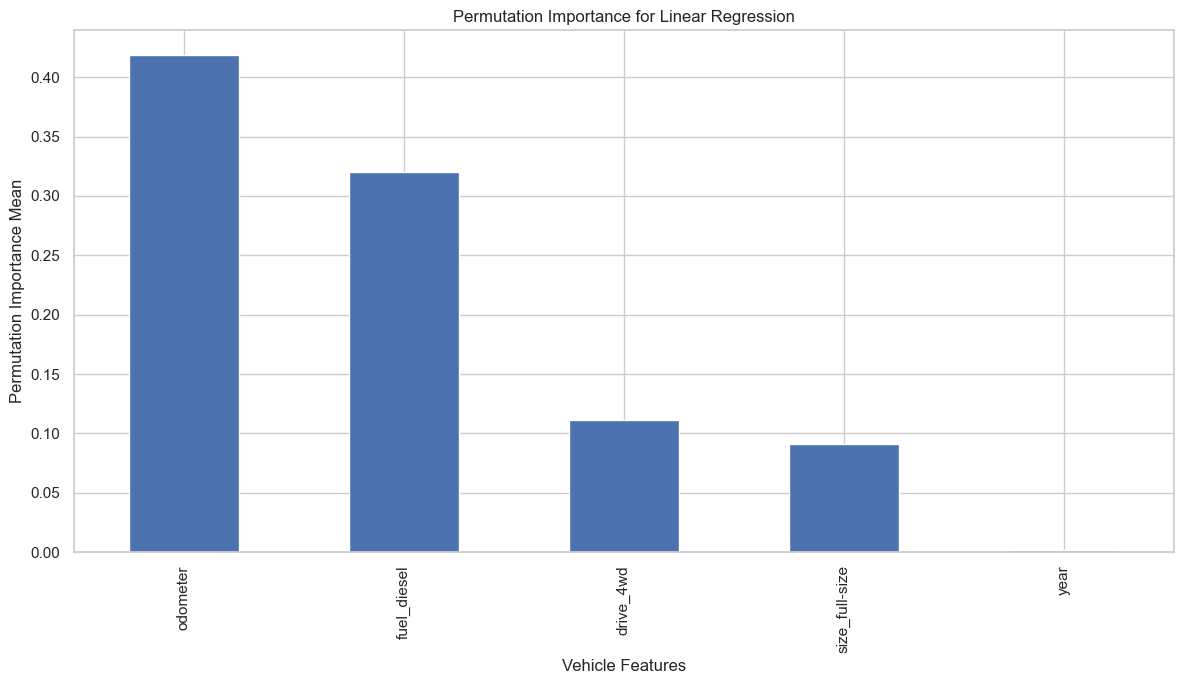

In [428]:
#### Linear Regression Model ####
import matplotlib.pyplot as pltLR

# major features for the model that affect the price of the vehicle
X8_LR = new_vehicle_data_1990_df[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y8_LR = new_vehicle_data_1990_df.price

# Split the data into training and testing sets (70% / 30%)
X8_train_LR, X8_test_LR, y8_train_LR, y8_test_LR = train_test_split(X8_LR, y8_LR, test_size=0.3, random_state=0)

# Linear Regression Model --- (Multiple Linear Regression)
LRmodel = LinearRegression(fit_intercept=False)
LRmodel.fit(X8_train_LR, y8_train_LR)

# Evaluate the Linear Regression Model
train_predictions_LR = LRmodel.predict(X8_train_LR)
test_predictions_LR = LRmodel.predict(X8_test_LR)

# Training Accuracy and RMSE
train_accuracy_LR = LRmodel.score(X8_train_LR, y8_train_LR)
train_rmse_LR = np.sqrt(mean_squared_error(y8_train_LR, train_predictions_LR))

# Test Accuracy and RMSE
test_accuracy_LR = LRmodel.score(X8_test_LR, y8_test_LR)
test_rmse_LR = np.sqrt(mean_squared_error(y8_test_LR, test_predictions_LR))

# Print performance metrics for Linear Regression
print(f"***********************\n")
print(f"Linear Regression Model:")
print(f"***********************\n")
print(f"Training Accuracy: {train_accuracy_LR * 100:.2f}%")
print(f"Training RMSE: {train_rmse_LR:.2f}")
print(f"Test Accuracy: {test_accuracy_LR * 100:.2f}%")
print(f"Test RMSE: {test_rmse_LR:.2f}")
print(f"Model Coefficients: {LRmodel.coef_}")
print(f"Model Intercept: {LRmodel.intercept_}\n")

# Prediction using Odometer, Year, fuel_diesel, drive_4wd and size_full-size as input
print(f"******************************************\n")
print(f"Linear Regression Model - Price Prediction:")
print(f"******************************************\n")
print(f"Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[100000, 1990, 1, 1, 1]])[0]:.2f}")
print(f"Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[100000, 1990, 0, 1, 1]])[0]:.2f}")
print(f"Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[10000, 2020, 1, 1, 1]])[0]:.2f}")
print(f"Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[10000, 2020, 0, 1, 1]])[0]:.2f}")

# Permutation Importance for Linear Regression
r_LR = permutation_importance(LRmodel, X8_test_LR, y8_test_LR, n_repeats=30, random_state=0)
perm_df_LR = pd.Series(r_LR.importances_mean, index=X8_test_LR.columns).sort_values(ascending=False)
perm_df_LR 

# Plot permutation importance for Linear Regression
pltLR.figure(figsize=(12, 7))
perm_df_LR.plot.bar()
pltLR.title("Permutation Importance for Linear Regression")
pltLR.ylabel("Permutation Importance Mean")
pltLR.xlabel("Vehicle Features")
pltLR.show()

***********************

Ridge Regression Model:
***********************

Training Accuracy: 55.66%
Training RMSE: 8354.41
Test Accuracy: 56.14%
Test RMSE: 8259.47
Model Coefficients: [-6.78353151e-02  8.43876927e+02  1.66544929e+04  5.15899283e+03
  5.38432707e+03]
Model Intercept: -1679521.4879967293

******************************************

Ridge Regression Model - Price Prediction:
******************************************

Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: $20207.88
Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: $3553.39
Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: $51629.37
Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: $34974.87


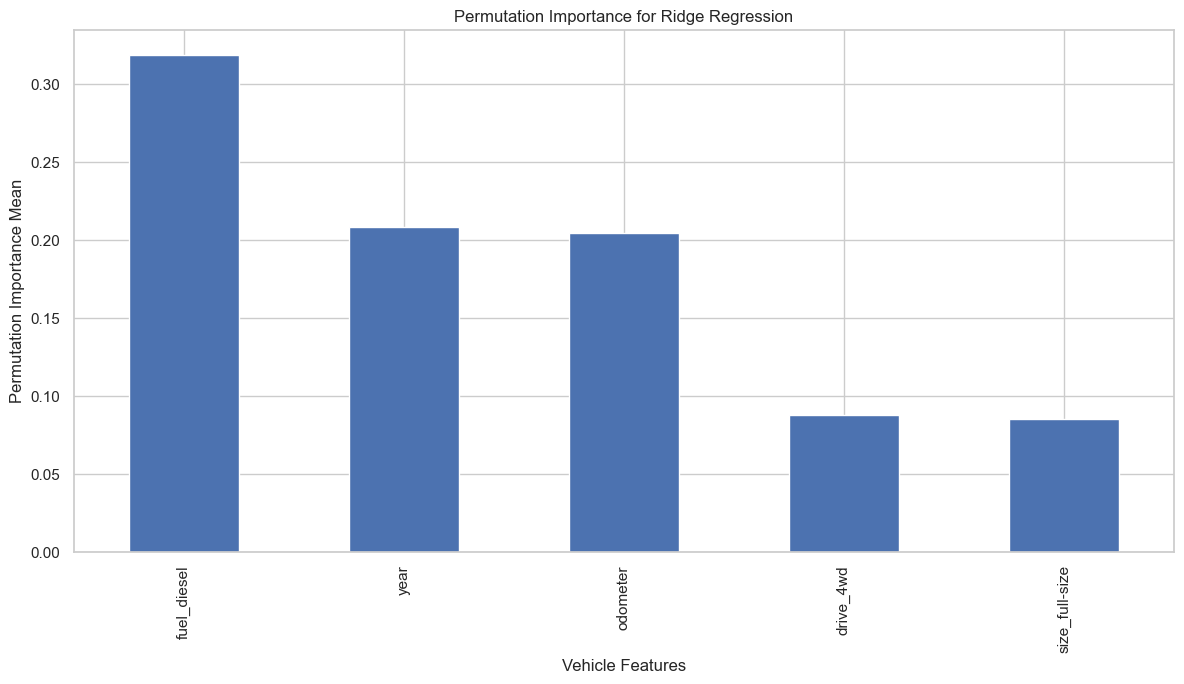

In [429]:
#### Ridge Regression Model #####
LRmodel = Ridge(alpha=1e-2).fit(X8_train_LR, y8_train_LR)
#LRmodel.score(X8_test_LR, y8_test_LR)

# Evaluate the Linear Regression Model
train_predictions_LR = LRmodel.predict(X8_train_LR)
test_predictions_LR = LRmodel.predict(X8_test_LR)

# Training Accuracy and RMSE
train_accuracy_LR = LRmodel.score(X8_train_LR, y8_train_LR)
train_rmse_LR = np.sqrt(mean_squared_error(y8_train_LR, train_predictions_LR))

# Test Accuracy and RMSE
test_accuracy_LR = LRmodel.score(X8_test_LR, y8_test_LR)
test_rmse_LR = np.sqrt(mean_squared_error(y8_test_LR, test_predictions_LR))

# Print performance metrics for Linear Regression
print(f"***********************\n")
print(f"Ridge Regression Model:")
print(f"***********************\n")
print(f"Training Accuracy: {train_accuracy_LR * 100:.2f}%")
print(f"Training RMSE: {train_rmse_LR:.2f}")
print(f"Test Accuracy: {test_accuracy_LR * 100:.2f}%")
print(f"Test RMSE: {test_rmse_LR:.2f}")
print(f"Model Coefficients: {LRmodel.coef_}")
print(f"Model Intercept: {LRmodel.intercept_}\n")

# Prediction using Odometer, Year, fuel_diesel, drive_4wd and size_full-size as input
print(f"******************************************\n")
print(f"Ridge Regression Model - Price Prediction:")
print(f"******************************************\n")
print(f"Vehicle with Year of 1990, 100k Miles with Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[100000, 1990, 1, 1, 1]])[0]:.2f}")
print(f"Vehicle with Year of 1990, 100k Miles with No Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[100000, 1990, 0, 1, 1]])[0]:.2f}")
print(f"Vehicle with Year of 2020, 10k Miles with Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[10000, 2020, 1, 1, 1]])[0]:.2f}")
print(f"Vehicle with Year of 2020, 10k Miles with No Diesel Fuel, 4WD and Full Size: ${LRmodel.predict([[10000, 2020, 0, 1, 1]])[0]:.2f}")

# Permutation Importance for Linear Regression
r_LR = permutation_importance(LRmodel, X8_test_LR, y8_test_LR, n_repeats=30, random_state=0)
perm_df_LR = pd.Series(r_LR.importances_mean, index=X8_test_LR.columns).sort_values(ascending=False)
perm_df_LR 

# Plot permutation importance for Linear Regression
pltLR.figure(figsize=(12, 7))
perm_df_LR.plot.bar()
pltLR.title("Permutation Importance for Ridge Regression")
pltLR.ylabel("Permutation Importance Mean")
pltLR.xlabel("Vehicle Features")
pltLR.show()


#### **Observations**

**Comparison of Linear and Ridge Regression Models**

##### **1. Model Performance (Training and Testing Metrics)**

|Metric                            | **Linear Regression**    | **Ridge Regression**      |
|----------------------------------|--------------------------|---------------------------|
| **Training Accuracy**            | 47.52%                   | 55.66%                    |
| **Training RMSE**                | 9089.08                  | 8354.41                   |
| **Test Accuracy**                | 48.26%                   | 56.14%                    |
| **Test RMSE**                    | 8970.29                  | 8259.47                   |

- **Ridge Regression** shows a higher accuracy and lower RMSE on both the training and testing datasets compared to **Linear Regression**.
- The lower RMSE indicates that the **Ridge Regression Model** performs better in predicting the vehicle prices with fewer errors compared to the **Linear Regression Model**, which suggests that the Ridge model is more generalizable.

##### **2. Model Coefficients and Intercept**

##### **Linear Regression Coefficients**:
- Coefficients include both positive and negative values, with the intercept at 0, this shows that the model does not include any additional offset or adjustment for the price prediction.

##### **Ridge Regression Coefficients**:
- The coefficients are smaller in magnitude than those in the linear model, this shows that Ridge Regression has applied regularization to the coefficients, helping reduce overfitting.
- The intercept in Ridge Regression is significantly negative, which is because of the regularization and does not necessarily imply a meaningful interpretation by itself.

##### **3. Price Predictions**

**Vehicle Description**| **Linear Regression Price** | **Ridge Regression Price** |
|----------------------------------------------------------|-----------------------------|---------------------------
| 1990 vehicle, 100k Miles, Diesel Fuel, 4WD, Full Size    | 39,107.49 | 20,207.88 
| 1990 vehicle, 100k Miles, No Diesel Fuel, 4WD, Full Size | 22,569.71 |  3,553.39  
| 2020 vehicle, 10k Miles, Diesel Fuel, 4WD, Full Size     | 48,238.24 | 51,629.37 
| 2020 vehicle, 10k Miles, No Diesel Fuel, 4WD, Full Size  | 31,700.45 | 34,974.87 


- The Linear Regression Model is returning prices that appear to be more inflated and unrealistic (e.g., 39,107 for a 1990 diesel vehicle with 100k miles vs. 20,207 in Ridge). This suggests that Linear Regression might be overfitting to the data, particularly with respect to older vehicles.
- Ridge Regression seems to give more reasonable price predictions, especially for older vehicles, where the prices are considerably lower compared to the linear model. It also provides more consistency in pricing, especially for newer vehicles like the 2020 model.

##### **Conclusion:**

- **Recommendation**: Based on the comparison of both models, **Ridge Regression** would be the recommended model for predicting used car prices in this case.

##### **Why Ridge Regression?**
1. **Better Accuracy and Lower RMSE**: Ridge Regression provides **higher accuracy** and **lower RMSE** compared to Linear Regression, indicating better performance and fewer errors, especially on the test dataset.
2. **More Realistic Price Predictions**: Ridge Regression produces more reasonable and consistent price predictions, especially for older vehicles, which the Linear Regression model overestimates.
3. **Regularization Advantage**: Ridge Regression’s ability to regularize the coefficients helps reduce overfitting, leading to a more generalized model that can handle new, unseen data better.

In summary, while both models can provide insights, **Ridge Regression** demonstrates superior performance and produces more realistic predictions, making it the better choice for this vehicle price prediction application.


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Key Observations: Data Quality and Preparation

The quality of the provided data is suboptimal, with several missing values and unrealistic entries. For example, $0 for price and 0 for the odometer reading are present. These values are not possible for used cars in real world. Attempting to replace these unrealistic or incorrect values using standardization or normalization techniques (like mean or median) for variables like price and odometer readings proved not much useful.

Looking at various vehicle-specific features present (like Fuel, Condition, Size, Type, Color), more context would be needed to replace the missing or unrealistic values appropriately. To perform a more accurate and realistic data preparation process, these additional features would need to be considered. 

We tried using OneHotEncoder and get_dummies methods. Then we saw the linear model complexity that minimized the test error value of 2 is similar to or identical to some of the previous model applications. This suggests that there is little to no difference between using OneHotEncoder and get_dummies for converting categorical variables into dummy/indicator variables.

As a result of these issues, I chose to remove the problematic records from the dataset. Additionally, we eliminated features such as ID, VIN, State, Manufacturer, and Model, as we did not believe they significantly impacted used car prices, more importantly for the given dataset.

**1. Linear regression model** with all the final dataset after data manipulation returned:

| **Vehicle Description**                                                       | **Price**         |
|---------------------------------------------------------------------------|-------------------|
| New vehicle with 100 miles, condition excellent, diesel engine, and four-wheel drive | -98,263.87  |
| New vehicle with 100 miles, condition good, electric engine, and front-wheel drive | 29,013.34   |
| Used vehicle with 50,000 miles, condition fair, gasoline engine, and rear-wheel drive | 265,518.29  |
| New vehicle with 10 miles, condition excellent, hybrid engine, and all-wheel drive | 78,206.97   |


It is clear from the results that the negative price for the new diesel car needs to be corrected. The high price for the used car with 50,000 miles should be reviewed for consistency, as it seems excessively high for a used vehicle with those specifications. These observations indicate that the data may need to be cleaned and adjusted before performing further analysis.



**2. Comparison of Sixth and Seventh Model**

`Sixth_Model`

Features selected: odometer, year, fuel_diesel, drive_4wd, and size_full-size, based on their correlation with price for vehicles with odometer > 5000 and price > 5000.

**Performance:**
Training:
Accuracy: 45.26% (on training data)
RMSE: 9,226.0
Testing:
Accuracy: 46.88% (on test data)
RMSE: 9,298.39

**Vehicle Price Predictions:**


| Vehicle Description | Price |
|---|---|
| 1990 vehicle, 100k miles, diesel fuel, 4WD, full-size | 38,785.04 |
| 1990 vehicle, 100k miles, no diesel fuel, 4WD, full-size | 22,417.60 |
| 2020 vehicle, 10k miles, diesel fuel, 4WD, full-size | 47,456.98 |
| 2020 vehicle, 10k miles, no diesel fuel, 4WD, full-size | 31,089.55 |

`Seventh_Model`

Features selected: odometer, year, fuel_diesel, drive_4wd, and size_full-size, filtered by odometer > 5000, price > 5000, and year > 1990.

**Performance:**
Training:
Accuracy: 47.52%
RMSE: 9,089.08
Testing:
Accuracy: 48.26%
RMSE: 8,970.29

**Vehicle Price Predictions:**

| Vehicle Description | Price |
|---|---|
| 1990 vehicle, 100k miles, diesel fuel, 4WD, full-size | 39,107.49 |
| 1990 vehicle, 100k miles, no diesel fuel, 4WD, full-size | 22,569.71 |
| 2020 vehicle, 10k miles, diesel fuel, 4WD, full-size | 48,238.24 |
| 2020 vehicle, 10k miles, no diesel fuel, 4WD, full-size | 31,700.45 |

**Comparison Observations:**

`Accuracy:`

Sixth_Model  : 45.26% (Training), 46.88% (Test)
Seventh_Model: 47.52% (Training), 48.26% (Test)

- The Seventh_Model performs slightly better, showing higher accuracy on both training and testing datasets.
RMSE:

Sixth_Model: 9,226.0 (Training), 9,298.39 (Test)
Seventh_Model: 9,089.08 (Training), 8,970.29 (Test)

- The Seventh_Model has a slightly lower RMSE, indicating better prediction accuracy with less error.

**Vehicle Price Predictions:**

The predicted prices for vehicles from both models are similar, with the Seventh_Model generally predicting slightly higher prices for cars from both the 1990 and 2020 years, especially for cars with diesel fuel and 4WD.

- For instance, for a 1990 vehicle with 100k miles, diesel fuel, 4WD, and full-size, the Seventh_Model predicts $39,107.49 vs $38,785.04 from the Sixth_Model.
- Similarly, for a 2020 vehicle with 10k miles, diesel fuel, 4WD, and full-size, the Seventh_Model predicts $48,238.24 vs $47,456.98 from the Sixth_Model.

In summary, the Seventh_Model shows slightly better performance in terms of both accuracy and RMSE, suggesting it may be a more reliable model for predicting vehicle prices in this dataset. The differences in predictions are minor, but they indicate a trend where the Seventh_Model slightly overestimates prices compared to the Sixth_Model.

**3. Eigth_Model - Multiple regression models (Ridge and Linear) with cross validation**

Let us look at the summary of the regression models based on their performance metrics and coefficients:

**Comparison of Linear and Ridge Regression Models**

##### **Model Performance (Training and Testing Metrics)**

|Metric                            | **Linear Regression**    | **Ridge Regression**      |
|----------------------------------|--------------------------|---------------------------|
| **Training Accuracy**            | 47.52%                   | 55.66%                    |
| **Training RMSE**                | 9089.08                  | 8354.41                   |
| **Test Accuracy**                | 48.26%                   | 56.14%                    |
| **Test RMSE**                    | 8970.29                  | 8259.47                   |

- **Ridge Regression** shows a higher accuracy and lower RMSE on both the training and testing datasets compared to **Linear Regression**.
- The lower RMSE indicates that the **Ridge Regression Model** performs better in predicting the vehicle prices with fewer errors compared to the **Linear Regression Model**, which suggests that the Ridge model is more generalizable.

##### **Model Coefficients and Intercept**

##### **Linear Regression Coefficients**:
- Coefficients include both positive and negative values, with the intercept at 0, this shows that the model does not include any additional offset or adjustment for the price prediction.

##### **Ridge Regression Coefficients**:
- The coefficients are smaller in magnitude than those in the linear model, this shows that Ridge Regression has applied regularization to the coefficients, helping reduce overfitting.
- The intercept in Ridge Regression is significantly negative, which is because of the regularization and does not necessarily imply a meaningful interpretation by itself.

##### **Price Predictions**

**Vehicle Description**| **Linear Regression Price** | **Ridge Regression Price** |
|----------------------------------------------------------|-----------------------------|---------------------------
| 1990 vehicle, 100k Miles, Diesel Fuel, 4WD, Full Size    | 39,107.49 | 20,207.88 
| 1990 vehicle, 100k Miles, No Diesel Fuel, 4WD, Full Size | 22,569.71 |  3,553.39  
| 2020 vehicle, 10k Miles, Diesel Fuel, 4WD, Full Size     | 48,238.24 | 51,629.37 
| 2020 vehicle, 10k Miles, No Diesel Fuel, 4WD, Full Size  | 31,700.45 | 34,974.87 


- The Linear Regression Model is returning prices that appear to be more inflated and unrealistic (e.g., 39,107 for a 1990 diesel vehicle with 100k miles vs. 20,207 in Ridge). This suggests that Linear Regression might be overfitting to the data, particularly with respect to older vehicles.
- Ridge Regression seems to give more reasonable price predictions, especially for older vehicles, where the prices are considerably lower compared to the linear model. It also provides more consistency in pricing, especially for newer vehicles like the 2020 model.

##### **Conclusion:**

- **Recommendation**: Based on the comparison of both models, **Ridge Regression** would be the recommended model for predicting used car prices in this case.
1. Ridge Regression provides **higher accuracy** and **lower RMSE** compared to Linear Regression, indicating better performance and fewer errors, especially on the test dataset.
2. Ridge Regression produces more reasonable and consistent price predictions, especially for older vehicles, which the Linear Regression model overestimates.
3. Ridge Regression’s ability to regularize the coefficients helps reduce overfitting, leading to a more generalized model that can handle new, unseen data better.

In summary, while both models can provide insights, **Ridge Regression** demonstrates superior performance and produces more realistic predictions, making it the better choice for this vehicle price prediction application.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.


### Introduction

This machine learning application was developed using a dataset containing over 400,000 used car sales spanning a century. The goal is to analyze the factors influencing car prices, helping your organization and sales team better understand what consumers value in used cars.

The primary objective is to provide valuable insights that will allow you to optimize your inventory based on consumer preferences, ultimately driving higher sales and increasing revenue.

The application follows a machine learning process, which begins with data collection, followed by cleaning, preparation, and manipulation of the dataset. The model is then trained, tested, and used to generate predictions and evaluate accuracy. To further enhance the model's performance, additional sales data should be continuously fed into the system, which will improve its predictions and provide more accurate insights into the factors that matter most to your customers.

#### Machine Learning and CRISP-DM Overview
Source: CRISP-DM: Towards a Standard Process Model for Data Mining by Rüdiger Wirth and Jochen Hipp

Source: [Machine Learning: A Quick Introduction and Five Core Steps](https://centricconsulting.com/blog/machine-learning-a-quick-introduction-and-five-core-steps/)


### Key Findings

**Data Processing**

Upon reviewing the provided data, it was clear that it was not clean. There were missing values, and several entries appeared unrealistic or incorrect for used vehicles—such as odometer readings of zero or single-digit values, and prices listed as zero or in single-digit amounts.

A summary of the data preparation process is as follows:

- **Remove records with zero prices and odometer values**  
- **Eliminate records with missing or incomplete data**
- **Converted categorical variables into dummy/indicator variables using OneHotEncoder/get_dummies methods**
- **Drop irrelevant features** (e.g., VIN, ID, region) that don’t significantly influence used car prices  
- **Review other factors** (e.g., state, paint color, manufacturer, transmission) to assess their potential impact on price, and remove those that do not contribute meaningfully to the model  
- **Filter the data** to include only cars manufactured in 1990 or later, as there were very few used cars from before 1990 in the dataset

**Data Application**

After preparing the data, we used the following factors to build the machine learning application:

- Price  
- Year  
- Condition  
- Fuel Type  
- Odometer  
- Drive Train  
- Size  

During the process of building and testing the application, we found that using vehicle records from years greater than 1990 resulted in the best accuracy for the dataset. This is because there were simply more records available from this period, based on the histogram we plotted earlier

The applications with Linear Regression Model achieved an accuracy of over 47% in predicting used vehicle prices, using factors such as odometer reading, year, fuel type, drive train, and size. Then we created and ran multiple regression models (Polynomial, Ridge and Linear) applications. The Ridge model achieved 53% accuracy. 

- The Ridge regression model performed the best in terms of accuracy with 55% and RMSE, shows a good balance, with some regularization preventing overfitting. Its performance is also better than other models.

- The linear regression model is somewhat less effective, with lower accuracy and higher errors, suggesting it is too simple for this data or more accurate data is needed.

When analyzing the factors influencing used vehicle prices in all these models, we identified the following order of importance:

1. Diesel Fuel  
2. Year  
3. Odometer  
4. Four-Wheel Drive  
5. Full Size  

In Summary, it appears that consumers prioritize vehicles with diesel fuel, followed by the model year and odometer reading (which are often correlated). For instance, newer vehicles tend to have lower mileage, although exceptions like rental vehicles do exist. Four-Wheel Drive (or All-Wheel Drive) and Full-Size vehicles ranked fourth and fifth in importance, respectively.

**Conclusion:**

In conclusion, **ridge regression** appears to be the best model for this dataset, as it achieves the highest accuracy and relatively moderate RMSE. Seventh_model or Linear regression could be a good alternative if we are concerned about overfitting, but linear regression might not be sufficient for capturing the underlying patterns.

The provided data is not fully clean, containing null values, NaNs, zeros, missing data, and unrealistic entries. Further filtering could help improve the dataset, such as by selecting used vehicle records with a manufacturing year of 2000 or later. This approach would allow the model to focus on newer vehicle features, such as model, cylinders, drive type, and size, which are more likely to influence the prices of newer used cars with lower odometer readings. This could also potentially lead to improved model accuracy.

Additionally, more comprehensive and higher-quality data should be collected to enhance the model. This data could include newer features of used cars, such as automated driving safety features, infotainment systems, cameras, remote start, and car mileage, all of which can impact used car prices.

**Next Steps**

While the current model (**Ridge regression model**) is ready for deployment, we recommend gathering additional high-quality data to build a model with an accuracy of 75% or higher. This model should be trained on used vehicle data no older than 10 years.

Additional datasets on used cars can be found on the [Used Cars Datasets Repository on Kaggle](https://www.kaggle.com/search?q=used+cars).
